In [8]:
import numpy as np
import pandas as pd
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statistics
import pickle
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

sns.set_style("darkgrid")

# A Better Model for Predicting Future Collections on Healthcare Procedures
Using 5 years of payment data for health care procedures, can we predict payments better than the current "Group Average" methodology being used?  The data consists of the following:
- 22 million claims for procedures from 2014 - 2018
- 25 descriptive features to explain:  Procedure performed, total charged, total paid, location, healthcare site metrics, payer data

# The Current "GRS" methodology 

Currently, to estimate payments, the following methodology is used:
- Aggregate previously adjudicated claims by payer grouping, region, and site (GRS) type by summing up the total charges and total payments
- For each grouping, calculate the ratio of payments to charges
- Apply the calculated ratio to claims that are not adjudicated (not complete) to create a payment estimate for charges outstanding

# Metrics for Model Evaluation
Thus, in order to improve the current model, we may investigate its results against 2 metrics:

1. Overall net payment prediction
2. Net payments at varying levels of granularity (different sample sizes)

## Procedure Claims by Year
A completed claim is one where the entire charge has been fully adjudicated (remaining charge after payment written off), while a claim with an outstanding charge is considered "Not Complete"

<img src="charges_by_year.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

## Sample of Descriptive Features
Available features describe the charge, payment, site where service took place, and data about the payer

<img src="sample_data.png" alt="Alt text that describes the graphic" title="Title text" />

# Model Development Process and Steps
In order to determine if a better model exists for predicting payments, the following steps were performed:

1. Visualize Charges and Payments
2. Test the Current Methodology
3. Develop and test a new model
4. Evaluate features and select final model
5. Potential future enhancements
6. Conclusion

## Visualize Charges and Payments
A break down of the payment structure to answer the following questions:

- On a daily basis, what is the average count of charges and how much is charged?
- What are the different types of typical charges?
- How long does it typically take for payment and are there patterns in payments?
- Bringing it all together:  Kernel Densiity estimation for charges and payments by Payer Grouping and top 4 procedures

### How many charges and how much is charged per day for healthcare procedures?

On average, there are about 14,000 charges, and total charges of $9 million per day.  Charges have steadily increased over the 4 year period, dropped slightly towards the end (the large drop is due to not all of the data being received for charges through May)

8891129.654733885


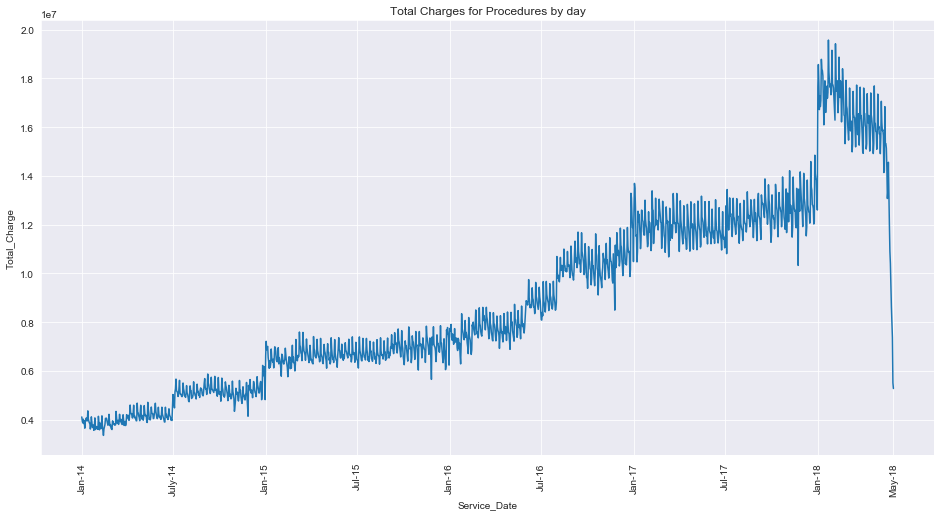

In [19]:
line_plot('Service_Date','Total_Charge', df_service_date_metrics,'Total Charges for Procedures by day',['2014-01-01','2014-07-01','2015-01-01','2015-07-01','2016-01-01','2016-07-01','2017-01-01','2017-07-01','2018-01-01','2018-05-31'], ['Jan-14','July-14','Jan-15','Jul-15','Jan-16','Jul-16','Jan-17','Jul-17','Jan-18','May-18'],"")
print(df_service_date_metrics.Total_Charge.mean())

13812.678039702234


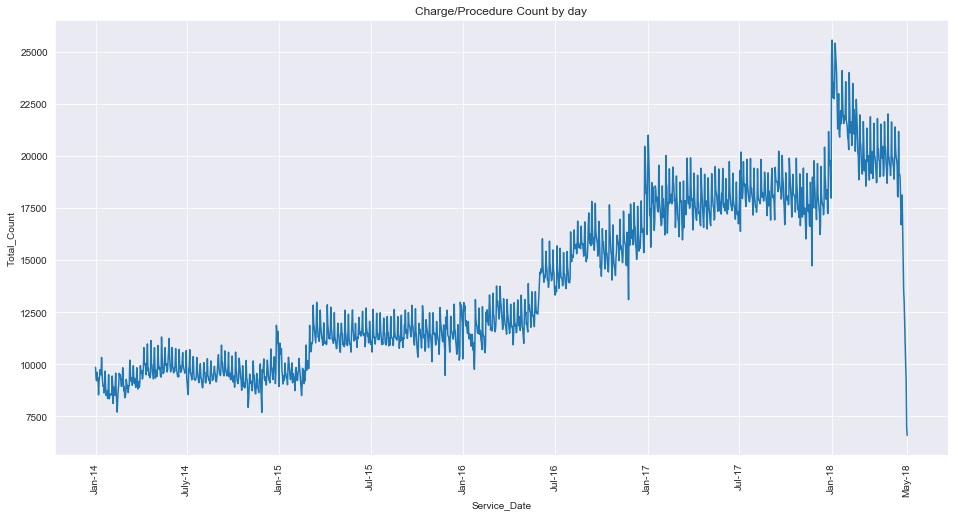

In [21]:
line_plot('Service_Date','Total_Count', df_service_date_metrics,'Charge/Procedure Count by day',['2014-01-01','2014-07-01','2015-01-01','2015-07-01','2016-01-01','2016-07-01','2017-01-01','2017-07-01','2018-01-01','2018-05-31'], ['Jan-14','July-14','Jan-15','Jul-15','Jan-16','Jul-16','Jan-17','Jul-17','Jan-18','May-18'],"")
print(df_service_date_metrics.Total_Count.mean())

In [5]:
#Load the data
# Parameters
server = 'JACKSON'
db = 'USACS'

# Create the connection
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')

In [20]:
#Create the dataframe
sql = """
SELECT isnull(wtd_avg_days_to_payment,0)  [Days to Payment (weighted)] from AM_tbl_Claims_Trans_GROUPED where AM_isFullyAdjudicatedStatus = 'Y' and Total_Charge > 0 
"""

df_wtd_pmt = pd.io.sql.read_sql(sql, conn)
df_wtd_pmt.head()

,Days to Payment (weighted)
0,44.000000
1,41.845159
2,29.000000
3,41.000000
4,31.000000


In [7]:
#Create the dataframe
sql = """
select
     AM_proc_code Procedure_Code
    ,[A&M grouping]
    ,Days_to_payment
    ,Cumulative_Payment_Ratio_Charge
    ,Total_Charge
    ,Total_Payment
from
    [AM_tbl_Payments_Fully_Adj_Charge_greater_zero] a
"""
df_pmt = pd.io.sql.read_sql(sql, conn)
df_pmt.head()

,Procedure_Code,A&M grouping,Days_to_payment,Cumulative_Payment_Ratio_Charge,Total_Charge,Total_Payment
0,99284,AETNA,28,0.639531,511.5,203.629997
1,99284,AETNA,28,0.319765,511.5,203.629997
2,99284,AETNA,42,0.398104,511.5,203.629997
3,99284,AETNA,200,0.398104,511.5,203.629997
4,99284,AETNA,20,0.147677,693.0,102.339996


In [9]:
#Create the dataframe
sql = """
select 
    AM_ID
    ,AM_proc_code Procedure_Code
    ,Days_to_payment 
    ,sum(Cumulative_Payment_Ratio_Charge) Cumulative_Payment_Ratio_Charge
from 
    AM_tbl_Payments_Fully_Adj_Charge_greater_zero 
group by
     AM_ID
    ,AM_proc_code 
    ,Days_to_payment
having
    sum(Cumulative_Payment_Ratio_Charge) <> 0
order by
    AM_ID,Days_to_payment
"""
df_pmt_2 = pd.io.sql.read_sql(sql, conn)
df_pmt_2.head()

,AM_ID,Procedure_Code,Days_to_payment,Cumulative_Payment_Ratio_Charge
0,1,99285,118,0.331666
1,18,Other,21,0.243956
2,21,99283,21,0.334663
3,28,99284,25,0.112414
4,36,99283,40,0.233638


In [19]:
#Create the dataframe
sql = """

select 
    Total_Charge
    ,Total_Payment
    ,Payment_Ratio
    ,[A&M grouping] AM_grouping
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and AM_isFullyAdjudicatedStatus = 'Y'
    
"""

#and YEAR(Service_Date) = '2018'
#    and Payment_Ratio between -10 and 50

df_grp_fa = pd.io.sql.read_sql(sql, conn)
df_grp_fa.head()

,Total_Charge,Total_Payment,Payment_Ratio,AM_grouping
0,751.750000,751.750000,100.000000,AETNA
1,511.500000,0.000000,0.000000,SELF-PAY
2,50.000000,0.000000,0.000000,AETNA
3,268.149994,209.100008,77.978748,AETNA
4,751.750000,170.090004,22.625873,MEDICARE


In [25]:
#Create the dataframe to see adjudicated status by month
sql = """


select
    Service_Yr_Month_decimal 
    ,AM_isFullyAdjudicatedStatus Fully_Adjudicated
    ,count(*) total_charges_procedures
From
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Service_date between '2016-01-01' and '2018-05-31'
group by
    Service_Yr_Month_decimal 
    ,AM_isFullyAdjudicatedStatus 
order by
    Service_Yr_Month_decimal 
    ,AM_isFullyAdjudicatedStatus desc

"""

df_fa_status_by_month = pd.io.sql.read_sql(sql, conn)
df_fa_status_by_month.head()

,Service_Yr_Month_decimal,Fully_Adjudicated,total_charges_procedures
0,2016.08,Y,358953
1,2016.08,N,871
2,2016.17,Y,343033
3,2016.17,N,904
4,2016.25,Y,382159


In [17]:
#Create the dataframe to see adjudicated status by month
sql = """

select
Service_Yr_Month_decimal 
,AM_proc_code Procedure_Code
,count(*) Total_Procedures
,sum(Total_Charge) Total_Charges
from
AM_tbl_Claims_Trans_GROUPED a
WHERE
    Service_date between '2016-01-01' and '2018-05-31'
group by
Service_Yr_Month_decimal
,AM_proc_code
order by
Service_Yr_Month_decimal
,AM_proc_code
"""


df_proc_status_by_month = pd.io.sql.read_sql(sql, conn)
df_proc_status_by_month.head()

,Service_Yr_Month_decimal,Procedure_Code,Total_Procedures,Total_Charges
0,2016.08,99283,53707,2.405634e+07
1,2016.08,99284,84386,7.199973e+07
2,2016.08,99285,72464,9.167668e+07
3,2016.08,99291,11055,1.805362e+07
4,2016.08,Other,138212,2.156525e+07


In [30]:
def bar_plot(x_col,y_col,df,plt_title,x_tick_list,label_list,hue_col,setTicks):
    fig = plt.figure(figsize=(16,8))
    fig.add_subplot(1,1,1)
    sns.set_style("darkgrid")
    if hue_col != "":
        ax = sns.barplot(x=x_col, y=y_col, hue=hue_col,data=df)
    else:
        ax = sns.lineplot(x=x_col, y=y_col, data=df)    

    if setTicks == True:
        ax.set_xticklabels(labels)
    else:
        plt.xticks(x_tick_list, label_list, rotation='vertical')
    
    plt.title(plt_title)
    plt.xticks(rotation=90)

In [18]:
def line_plot(x_col,y_col,df,plt_title,x_tick_list,label_list,hue_col):
    fig = plt.figure(figsize=(16,8))
    fig.add_subplot(1,1,1)
    sns.set_style("darkgrid")
    if hue_col != "":
        ax = sns.lineplot(x=x_col, y=y_col, data=df, hue=hue_col)
    else:
        ax = sns.lineplot(x=x_col, y=y_col, data=df)    
    
    plt.title(plt_title)
    plt.xticks(x_tick_list, label_list, rotation='vertical')
    plt.xticks(rotation=90)

In [3]:
#Plotting functions
def violin_plot(df, cat, val, val_param_1,val_param_2, title, plt_order,num_loc):
    
    # Create Dataframe
    df_plot = df.loc[(df[val]>=val_param_1) & (df[val]<val_param_2),[cat, val]]
    
    if plt_order == 'desc':
        grp_order =  df.groupby([cat]).apply(lambda x: len(x)).sort_values(ascending=False)
    else:
        grp_order =  df.groupby([cat])[val].median().sort_values(ascending=True)
        
    medians = df_plot.groupby([cat])[val].median()
    nobs =  df_plot.groupby([cat]).apply(lambda x: '{:,}'.format(len(x)))

    fig = plt.figure(figsize=(18,12))
    fig.add_subplot(1,1,1)
    ax = sns.violinplot(x=df_plot[cat], y=df_plot[val], legend=False, order=list(grp_order.index))
    num_am_grouping = df[cat].nunique()

    for tick, label in enumerate(ax.get_xticklabels()):
        grp = label.get_text()
        num = nobs[grp]
        ax.text(tick, num_loc, num,
        horizontalalignment='center', size='small', color='black',weight='semibold')

    plt.xticks(rotation=30)
    plt.title(title)
    plt.show() 

In [4]:
#Plot of function to estimate payment over time
def pmt_plot(df, x_col, y_col, grp, legout, xlim1, xlim2, ylim1, ylim2,plt_title, plt_x, plt_y, figsize1, figsize2):
    if grp == '':
        g = sns.lmplot(x=x_col, y=y_col, data=df, scatter=False, lowess=True, legend_out=legout)
    else:
        g = sns.lmplot(x=x_col, y=y_col, data=df,hue=grp, scatter=False, lowess=True, legend_out=legout)
    
    plt.xlim(xlim1,xlim2)
    plt.ylim(ylim1,ylim2)
    plt.title(plt_title)
    plt.xlabel(plt_x)
    plt.ylabel(plt_y)
    g.fig.set_size_inches(figsize1,figsize2)
    plt.show()

### What are the different types of typical charges?

- There are 4 prominent charges (represented as bumps in the distribution)
- The 4 charges map to the most common procedures
- Charges are typically between \$0 and \$1,800

<img src="violin_grp.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

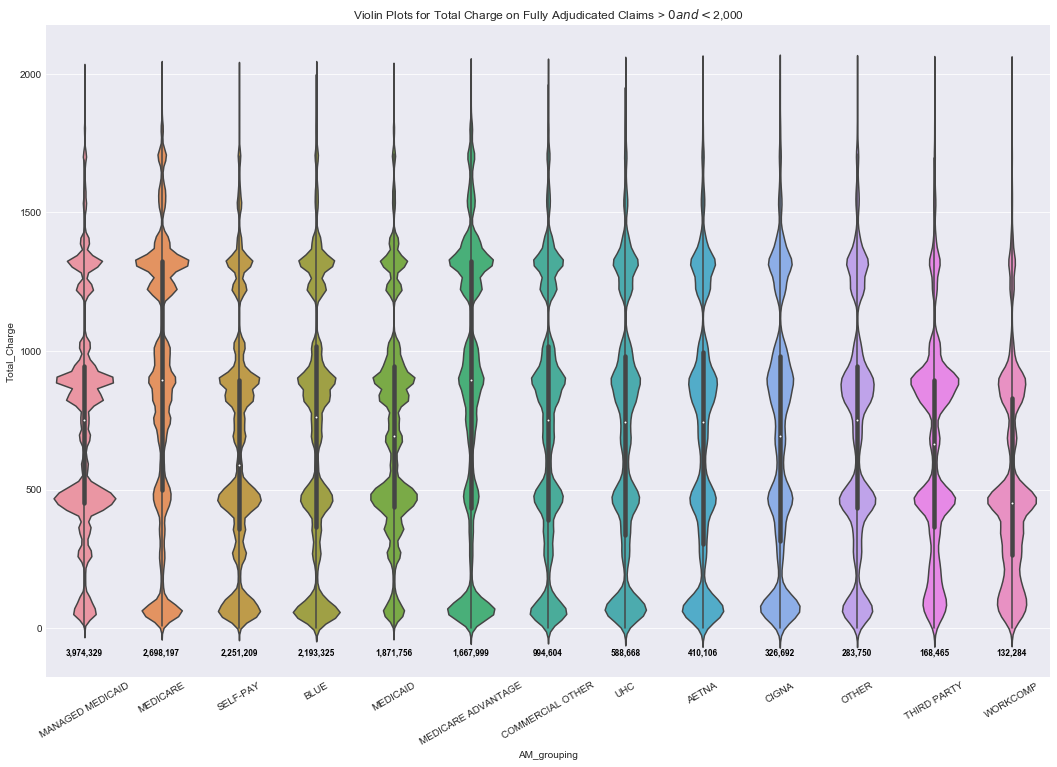

In [33]:
#Visualize the shape of charges
violin_plot(df_grp_fa, 'AM_grouping', 'Total_Charge', -700,2000,'Violin Plots for Total Charge on Fully Adjudicated Claims > $0 and <$2,000','desc',-100)

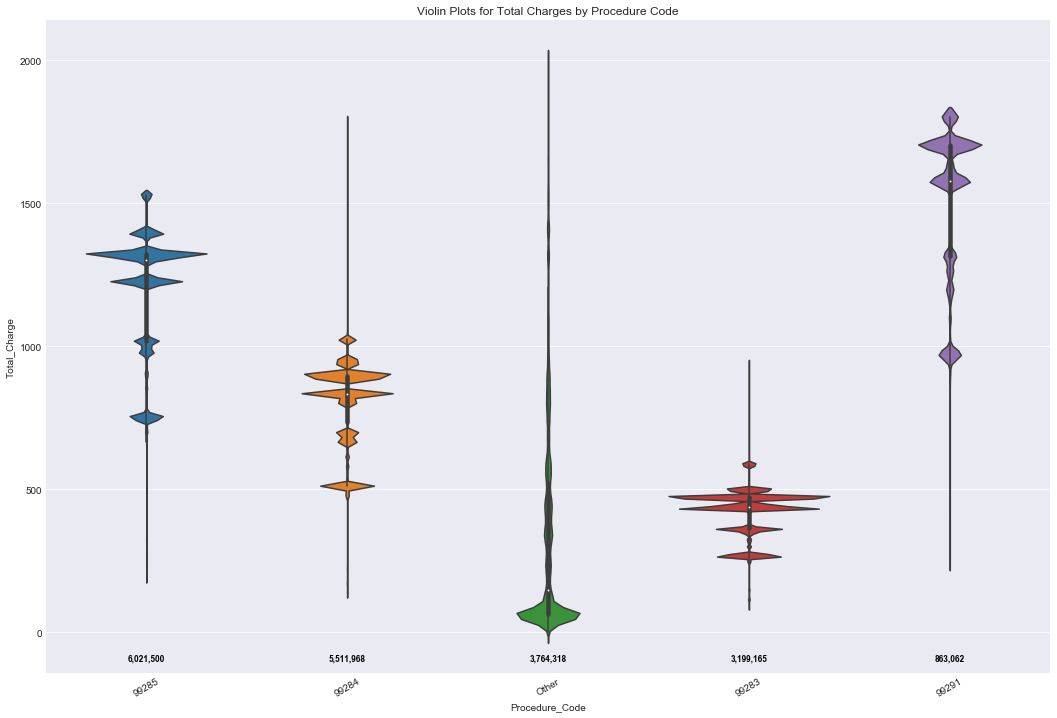

In [355]:
#Plots for total charges by procedure code
violin_plot(df_pmt, 'Procedure_Code', 'Total_Charge', -700,2000,'Violin Plots for Total Charges by Procedure Code','desc',-100)

Procedure Count by Month


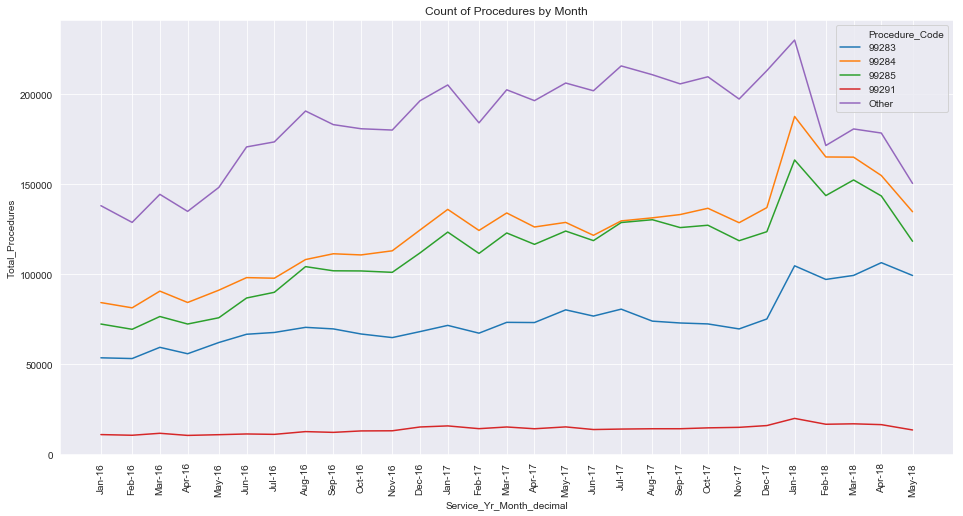

In [22]:
line_plot('Service_Yr_Month_decimal','Total_Procedures', df_proc_status_by_month,'Count of Procedures by Month',sorted(list(set(df_proc_status_by_month['Service_Yr_Month_decimal']))), ['Jan-16','Feb-16','Mar-16','Apr-16','May-16','Jun-16','Jul-16','Aug-16','Sep-16','Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18','Apr-18','May-18'],"Procedure_Code")
print('Procedure Count by Month')

Procedure Count by Month


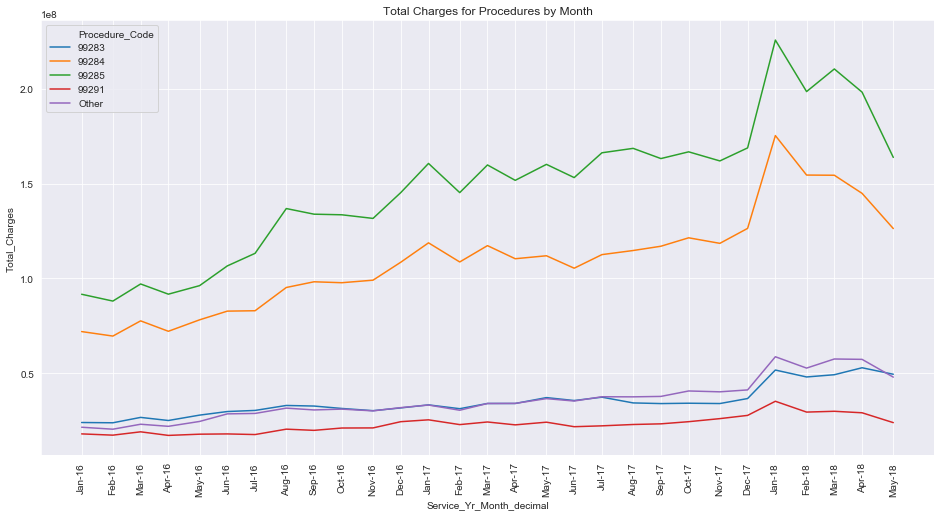

In [23]:
line_plot('Service_Yr_Month_decimal','Total_Charges', df_proc_status_by_month,'Total Charges for Procedures by Month',sorted(list(set(df_proc_status_by_month['Service_Yr_Month_decimal']))), ['Jan-16','Feb-16','Mar-16','Apr-16','May-16','Jun-16','Jul-16','Aug-16','Sep-16','Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18','Apr-18','May-18'],"Procedure_Code")
print('Procedure Count by Month')

<img src="violin_grp_payments.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

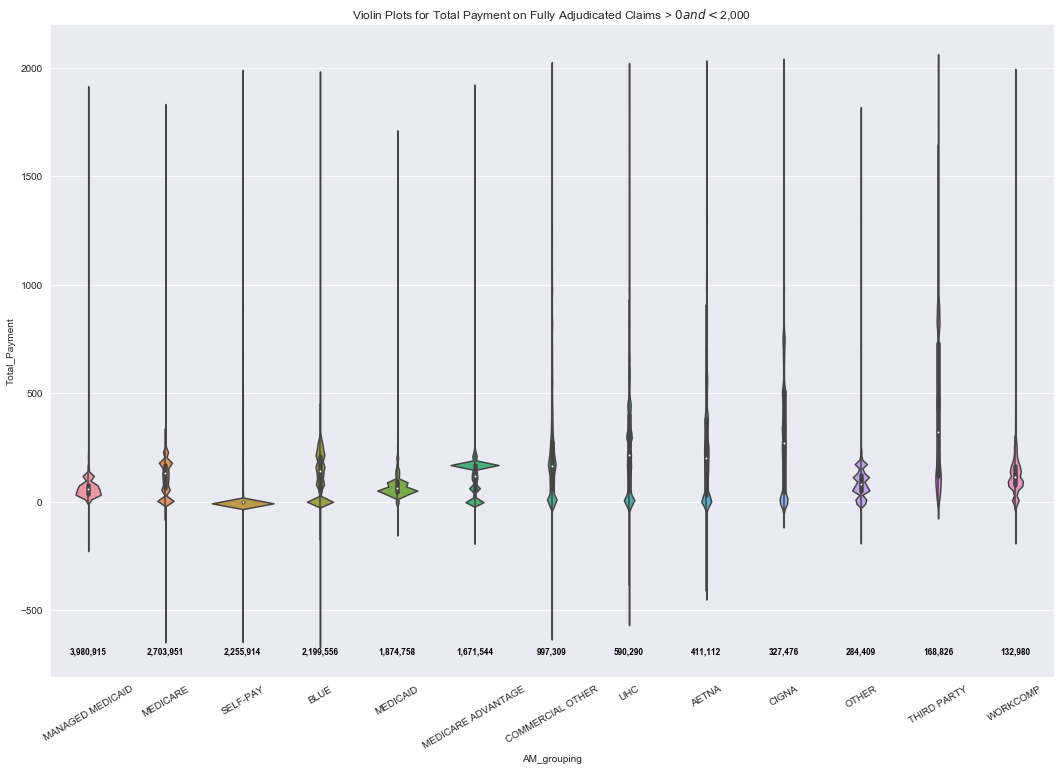

In [75]:
#Visualize the shape of payments
violin_plot(df_grp_fa, 'AM_grouping', 'Total_Payment', -700,2000,'Violin Plots for Total Payment on Fully Adjudicated Claims > $0 and <$2,000','desc',-700)

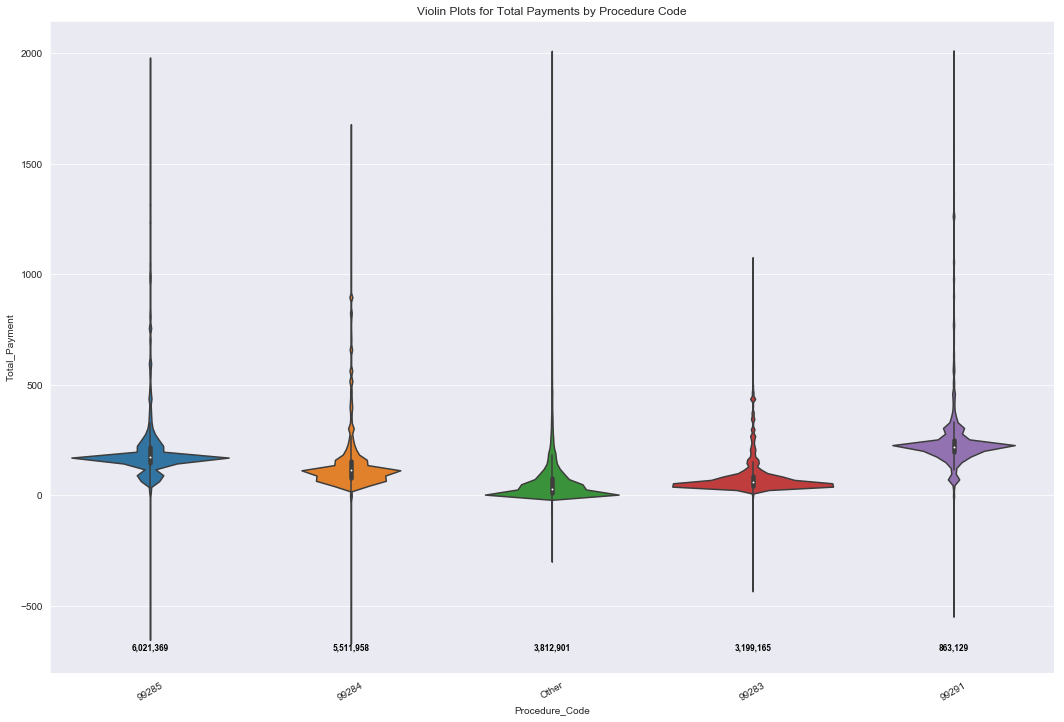

In [76]:
violin_plot(df_pmt, 'Procedure_Code', 'Total_Payment', -700,2000,'Violin Plots for Total Payments by Procedure Code','desc',-700)

## How long does it typically take for payment and are there patterns in payments?

- The median number of days (weighted) till payment is 29 days
- Typically, the majority of payments are made between 2 and 8 weeks
- Nearly all claims are adjudicated within 1 year (2% of charges are unadjudicated from 1 year ago)
- Different procedures have slight variations on time-to-payment
- Payer groupings vary widely in percentage paid on charges (10% - 50%)
- Payments are typically between \$0 and \$300

Median:


29.0

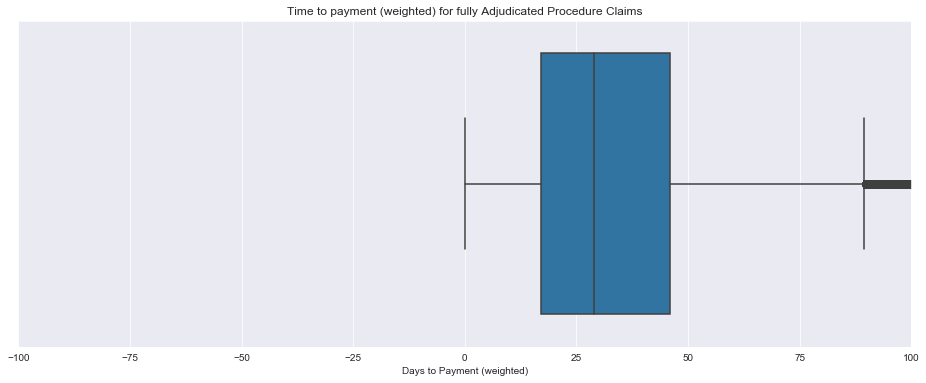

In [29]:
#fully adjudicated claims are typically paid in 29 days.
fig = plt.figure(figsize=(16,6))
fig.add_subplot(1,1,1)
sns.set_style("darkgrid")
ax = sns.boxplot(x=df_wtd_pmt["Days to Payment (weighted)"])
ax.set(xlim=(-100, 100))
plt.title('Time to payment (weighted) for fully Adjudicated Procedure Claims')
print("Median:")
df_wtd_pmt["Days to Payment (weighted)"].median()

Weighted time to payment


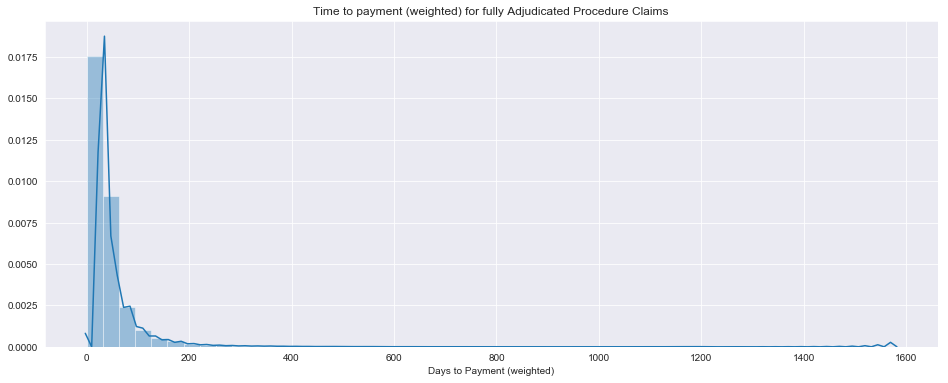

In [30]:
fig = plt.figure(figsize=(16,6))
fig.add_subplot(1,1,1)
sns.set_style("darkgrid")
ax = sns.distplot(df_wtd_pmt["Days to Payment (weighted)"])
plt.title('Time to payment (weighted) for fully Adjudicated Procedure Claims')
print('Weighted time to payment')

Total Charges by month for Fully adjudicated vs. non-fully adjudicated


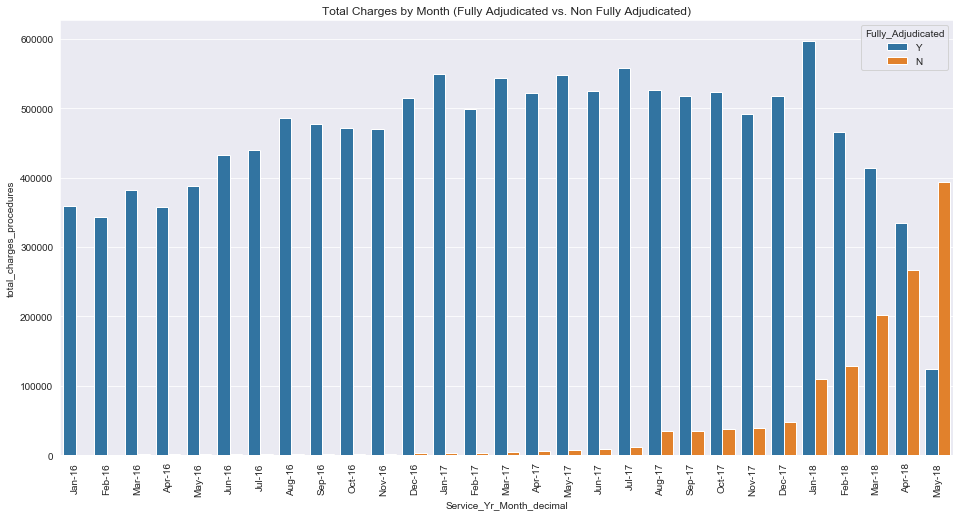

In [31]:
bar_plot('Service_Yr_Month_decimal','total_charges_procedures', df_fa_status_by_month,'Total Charges by Month (Fully Adjudicated vs. Non Fully Adjudicated)',sorted(list(set(df_fa_status_by_month['Service_Yr_Month_decimal']))), ['Jan-16','Feb-16','Mar-16','Apr-16','May-16','Jun-16','Jul-16','Aug-16','Sep-16','Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18','Apr-18','May-18'],"Fully_Adjudicated",True)
print('Total Charges by month for Fully adjudicated vs. non-fully adjudicated')

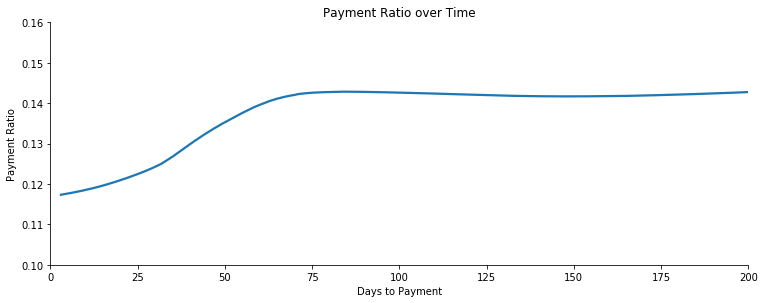

In [16]:
#Payment ratio over time
pmt_plot(df_pmt, 'Days_to_payment', 'Cumulative_Payment_Ratio_Charge', '', True, 0, 200, .10, .16, 'Payment Ratio over Time', 'Days to Payment', 'Payment Ratio',12,4)

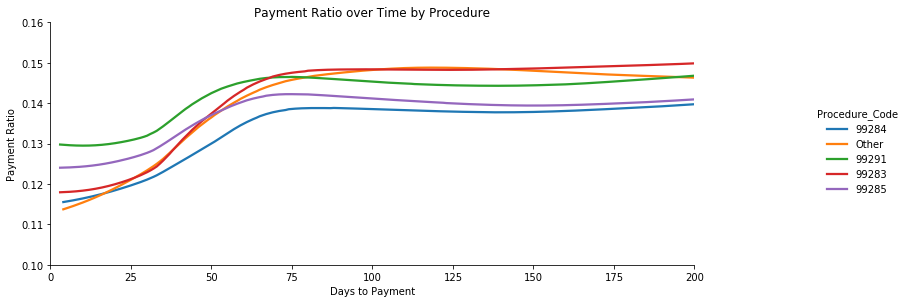

In [17]:
#Payment ratio over time by procedure code
pmt_plot(df_pmt, 'Days_to_payment', 'Cumulative_Payment_Ratio_Charge', 'Procedure_Code', True, 0, 200, .10, .16, 'Payment Ratio over Time by Procedure', 'Days to Payment', 'Payment Ratio',14,4)

<img src="pmt_ratio_grp.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

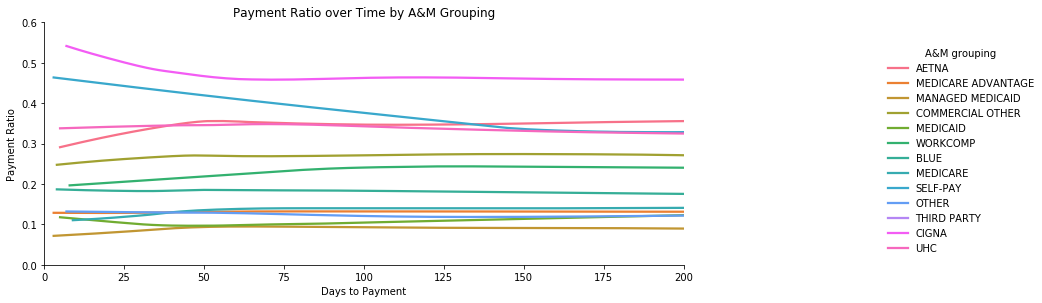

In [18]:
#Payment ratio over time by procedure code
pmt_plot(df_pmt, 'Days_to_payment', 'Cumulative_Payment_Ratio_Charge', 'A&M grouping', True, 0, 200, 0, .60, 'Payment Ratio over Time by A&M Grouping', 'Days to Payment', 'Payment Ratio',16,4)

## Bringing it all together:  Kernel Densiity estimation for charges and payments by Payer Grouping and top 5 procedures

- While Payer grouping and procedure help to explain payment rates and charge amounts, charges and payments still have different patterns/distributions.

Later, to estimate payments more precisely, we will attempt to bring in additional features to improve this estimate.  Features will include:  Service date, Site of procedure, location, and additional payer data.

Text(0.5,1,'Charges and Payments Kernel Density Estimation')

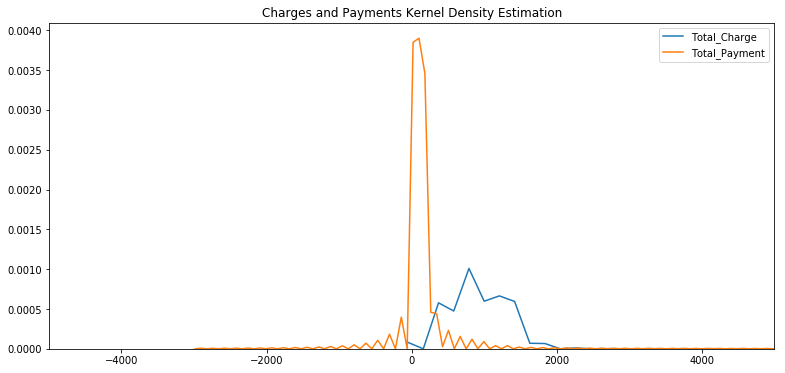

In [21]:
plt.figure(figsize=(13, 6))
plt.subplot(1, 1, 1)
sns.kdeplot(df_pmt['Total_Charge'], legend=True)
sns.kdeplot(df_pmt['Total_Payment'], legend=True)
plt.xlim(-5000,5000)
plt.title('Charges and Payments Kernel Density Estimation')

<img src="facet1.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

<img src="facet2.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

<img src="facet3.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


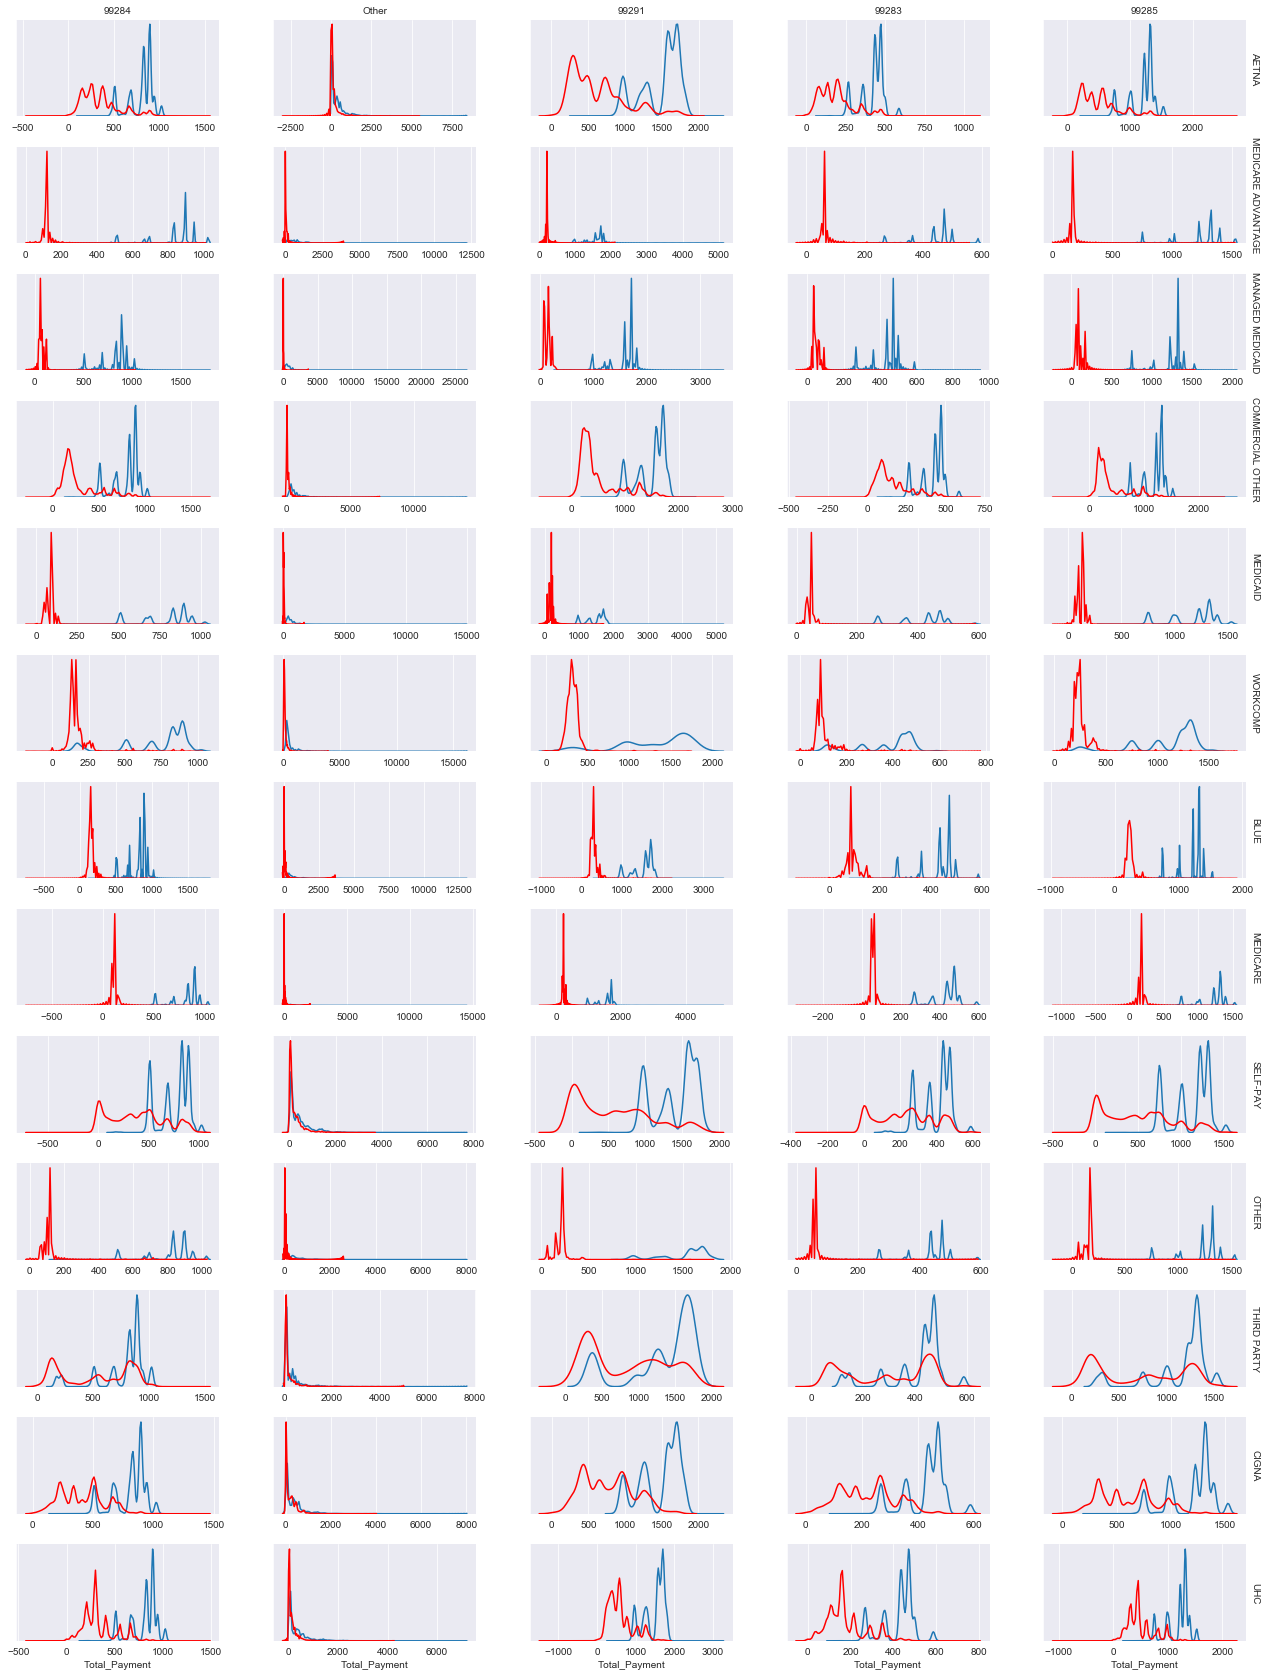

In [81]:
#Facetgrid for procedures and by grouping
g = sns.FacetGrid(df_pmt, row='A&M grouping', col='Procedure_Code', size=1.8, aspect=2,sharex=False, sharey=False, margin_titles=True)
g = g.map(sns.kdeplot, "Total_Charge")
g = g.map(sns.kdeplot, "Total_Payment", color='r')

#Format how row and column are displayed
[plt.setp(ax.texts, text="") for ax in g.axes.flat] 
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set(yticks=[])

# Test the Current Methodology

To test the methodology, the following steps were performed:


1. Choose a point in time where most of the charges are now fully adjudicated (so we can test a prediction from that point in time).  Reviewing the above adjudicated vs. unadjudicated bar plot, we selected Jan 31st, 2017 where 99% of total charges are now fully adjudicated.    
2. Use data for fully adjudicated charges prior to Jan 31st, 2017 to calculate the "GSR" ratio to apply (training set)
3. Apply the ratio to the set of charges as of Jan 31st 2017 that were not fully adjudicated at that time (test set).  
4. Evaluate performance on 2 metrics:  
    -  Overall net difference: (Actual - Predicted)/Actual (excluding known payments made)
    -  Net difference as a percentage for different sample sizes

## The "GSR" Model's overall prediction of payments is off by 11.5%
By applying the caclulated ratio of the average for group, site, and region, the predicted amount is off overall by 11.5%, and stabilizes around this amount once you look at a sample size greater than 100.

<img src="GSR_results.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

# Develop and Test a new model using a training sample

Developing and testing a new model includes the following steps:

1.  Use all columns in a lasso regression model to predicts payments.  Due to the large number of columns, we will use a sample of 350,000 rows for training. Further, a lasso regression will be useful for potential feature selection, by zero-ing out coefficients with negligible impact to the model.
2.  Use all columns in a random forest model to predicts payments.  Due to the large number of columns, we will use a sample of 350,000 rows for training. Similarly, we will investigate feature importances to assist with feature selection.


## Lasso Regression produces similar results to the "GSR" model

<img src="Lasso_results.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

## Random Forest Model narrows the difference to 2%

<img src="rf_all_results.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

# Evaluate Features and Select a final model

Based on the above 2 models we will investigate key features by doing the following:

1.  Investigate the most influential features based on the Lasso regression coefficients and random forest feature importances
2.  Select a subset of features to re-run the random forest model, as well as a multi-layered perceptron, and an ensemble bagging regressor.
3.  Select the model that produces the least difference on the entire test set.
4.  Follow the same process using the final model and features for the next 2 subsequent months (where the vast majority of charges are fully adjudicated) and confirm the results are similar.

## The Feature set may be reduced to 6 key features based on the results from the random forest and lasso regression models  

The six key features we will use to create a model using all of the training data are:

- Service Year/Month
- Grouping
- Procedure Code
- Total charge
- Site Volume
- Region

<img src="feature_imp.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

<img src="lasso_coeff.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

<img src="feature_imp_2.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

<img src="lasso_coeff_2.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

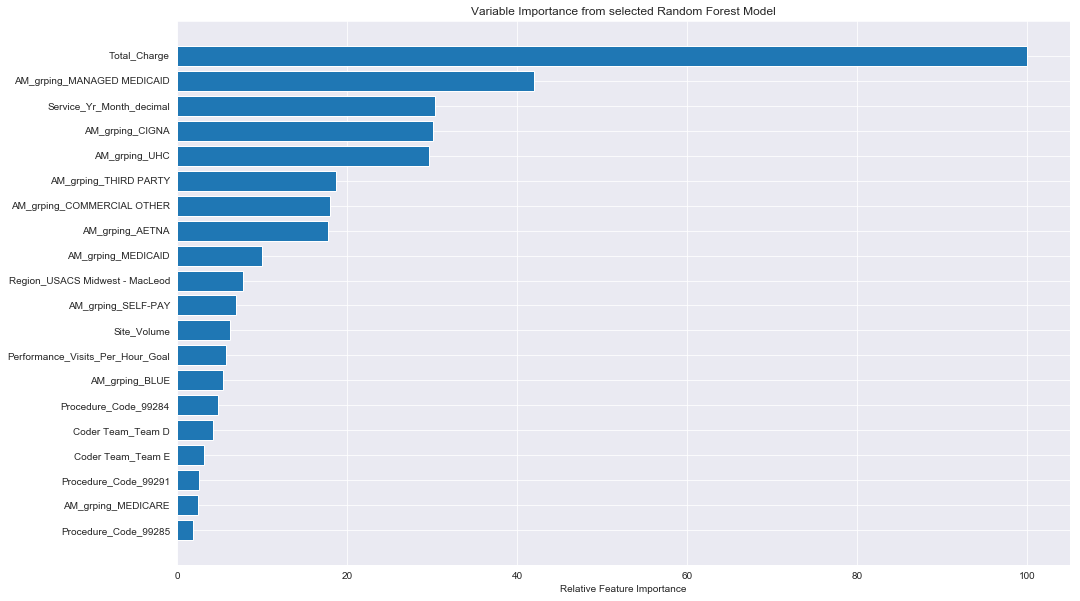

In [247]:
# Make importances relative to max importance.
feature_importance = rfr_all.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(16,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, rfr_all_cols[sorted_idx])
plt.xlabel('Relative Feature Importance')
plt.title('Variable Importance from selected Random Forest Model')
plt.show()

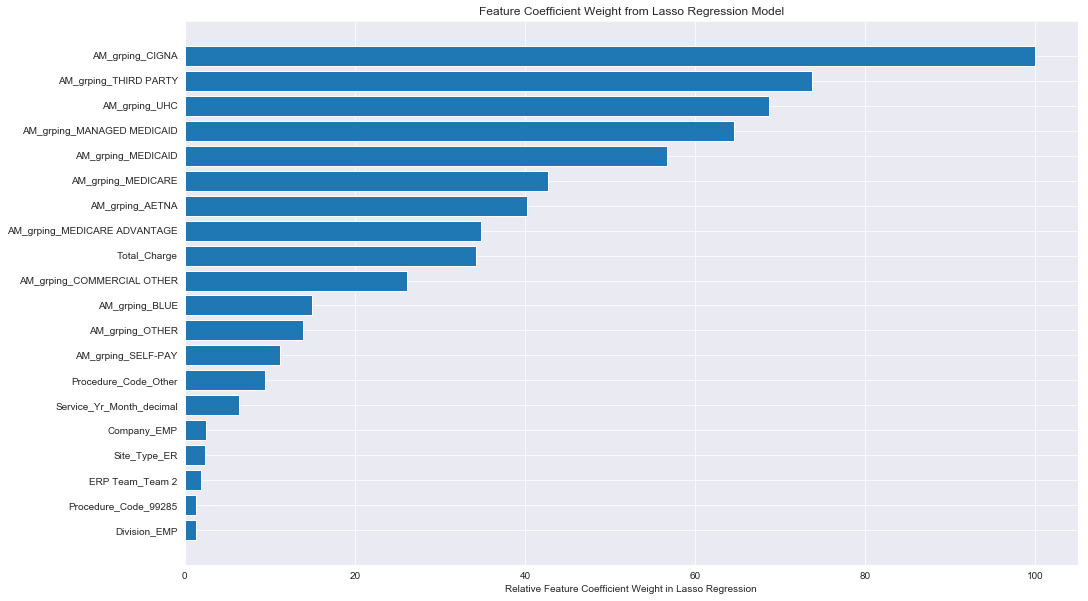

In [246]:
# Make importances relative to max importance.
lasso_coeffs = lso_all.coef_
lasso_coeffs = 100.0 * (abs(lasso_coeffs) / abs(lasso_coeffs).max())
sorted_idx = np.argsort(lasso_coeffs)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(16,10))
plt.barh(pos, lasso_coeffs[sorted_idx], align='center')
plt.yticks(pos, lso_all_cols[sorted_idx])
plt.xlabel('Relative Feature Coefficient Weight in Lasso Regression')
plt.title('Feature Coefficient Weight from Lasso Regression Model')
plt.show()

# Re-running the multi-layer perceptron using the reduced "key" feature set

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function by training on a dataset, where m is the number of dimensions for input and o is the number of dimensions for output. Given a set of features X = {x_1, x_2, ..., x_m} and a target y, it can learn a non-linear function approximator for regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. (Difference of 2.92%)


# Re-running the random forest using the reduced "key" feature set

Random Forest:  A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default). (Difference of .80%)

# Re-running the ensemble bagging regressor using the reduced "key" feature set
Ensemble Bagging Regressor: A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. (Difference of .41%)

## Multi-Layered Perceptron:  Difference of 2.92%

<img src="mlp_key_results.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

## Random Forest:  Difference of .80%

<img src="rf_key_results.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

## Ensemble Bagging Regressor:  Difference of .41%

<img src="bag_key_results.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

## Repeating the Process for February and March
Utilizing the same process for 3 months, the results of using the Ensemble Bagging Reggressor are:

1. January:  11.49% --> .41%
1. February:  10.60% --> .62%
2. March:  11.10% --> .46%

Thus, using an Ensemble Bagging Regressor and 6 key columns (Grouping, Service Year/Month, Procedure Code, Total Charges, Site Volume, and Region) may reduce the difference from the "GSR" averaging method from ~11% to ~.5%. 

Given that there are 14,000 transacations for $9 million worth of charges daily, the Ensemble Bagging Regressor model estimates payments within < 1% of the final payment collected on the charge.

## February GSR:   10.6%

<img src="gsr_0228_2.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

## February Ensemble Bagging Regressor:  .62%

<img src="bag_0228.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

## March GSR:   11.10%

<img src="gsr_0331_2.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

## March Ensemble Bagging Regressor:  .46%

<img src="bag_0331.png" alt="Alt text that describes the graphic" title="Title text" align="left" />

# Potential Future Enhancements

An Ensemble bagging regressor model can predict the payments on charges for medical procedures on a daily basis within 1% by using 4 additional features (Procedure Code, Site Volume, Service Year/Month, and Total Charge).  The current method predicts payments less accurately (within 10%) using Group, Site, and Region.  However, some potential enhancements may help to increase accuracy at an even more granular level, or even at the individual charge level.  These enhancements include:

Hyperparameter tuning of the Ensemble Bagging Regressor:  
-  n_estimators:   Number of estimators in the ensemble
-  max_features:   The number of features to draw from X to train each base estimator
-  max_samples:  The number of samples to draw from X to train each base estimator.    

# Potential Future Enhancements continued

Adding and removing additional features:  
- Use the feature_selection transformer with varying threshholds to discover potential additional features

By training new models with potentially different features, and modified model parameters, we can assess the model results by evaluating whether the difference decreases for different levels of granularity along with the standard deviation.  Using GridsearchCV may be useful for testing many variations of differnt hyperparameters to optimize the model.

# Conclusion

The current method for predicting payments on charges for medical procedures involves taking an average of 3 features from past data, and applying the average to charges that have not been paid.  We call this the "GSR" methodology.

We tested the accuracy of those results by selecting points in time where the charges were 99% paid and we can test how well a historical average will do as of that point in time.  The resulting prediction is approximately 11% higher than the actual payments collected over time.


Using an ensemble bagging regressor model, we can reduce the difference in the prediction to less than 1%.  The full process includes:
1.  Aggregating the data by claim and procedure code.  There are only 7 columns required for prediction:  Total Charge, Total Payment, Service Year/Month, Grouping, Procedure, Site Volume, Region).  
2.  Train an Ensemble Regressor Model using the Total Payment as the y-variable.  Total Charge, Service Year/Month, and Site Volume are scaled (Month/year presented as year with decimal for month where 2015.50 = June 2015).  Grouping, Procedure, and Region are treated as dummy variables where the top 4 procedures are classified as such, and the remaining are bucketed into "Other"
3.  Apply the model to Non-adjudicated claims and evaluate the differences/results with the "GSR" methodology.

# Questions/Comments?


Model Comparison


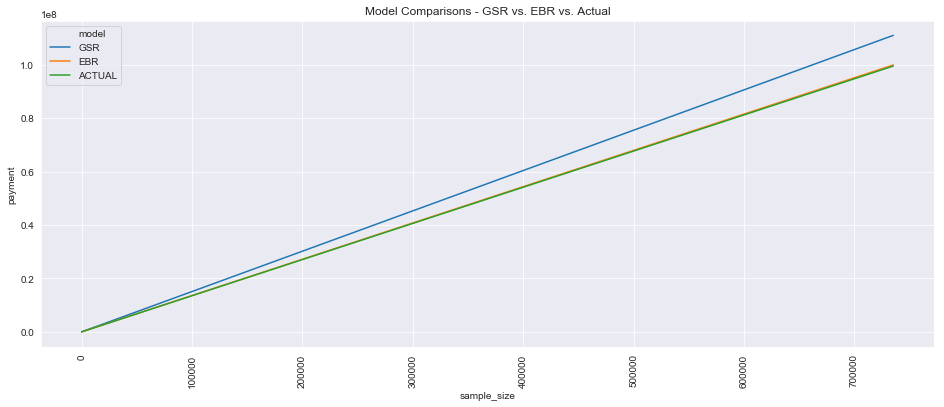

In [36]:
#fully adjudicated claims are typically paid in 26 days.
fig = plt.figure(figsize=(16,6))
fig.add_subplot(1,1,1)
sns.set_style("darkgrid")
ax = sns.lineplot(x="sample_size", y="payment",hue ="model", data=df_final_chart)
plt.title('Model Comparisons - GSR vs. EBR vs. Actual')
plt.xticks(rotation=90)
print('Model Comparison')

In [16]:
#charges by service date
sql = """

select 
    *
from 
    AM_conclusion_chart
"""

df_final_chart = pd.io.sql.read_sql(sql, conn)
df_final_chart.head()

,sample_size,payment,model
0,1,142.1288,GSR
1,5,743.8776,GSR
2,10,1531.9100,GSR
3,50,7545.6490,GSR
4,100,15008.9900,GSR


In [204]:
#Create the test set dataframe
#and Service_Yr_Month in ('2017_1'
sql = """

select
    AM_ID, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    Service_Yr_Month_decimal, 
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170131,
    Site_Volume,
    Performance_Visits_Per_Hour_Goal,
    Site_Mnem, 
    Site_Trauma, 
    Site_Pediatric,
    Site_Zip,
    Site_Status,
    Site_Type,
    Billing_Area_Mnem,
    Region, 
    'ID_' + cast(Primary_Payer_ID as varchar(20)) Payer,
    [A&M grouping] AM_grping,
    Company,
    Rendering_Type, 
    Performance_Include_By_Default,
    Exclude_From_ED, 
    Division, 
    Site_Mapping_Company, 
    [ERP Team], 
    [Coder Team], 
    Workday_Status 
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-01-31'
    and max_payment_date > '2017-01-31'

    
"""

X_test_all_cols = pd.io.sql.read_sql(sql, conn)
X_test_all_cols.head()

,AM_ID,AM_grp,Service_Yr_Month_decimal,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170131,Site_Volume,Performance_Visits_Per_Hour_Goal,Site_Mnem,...,AM_grping,Company,Rendering_Type,Performance_Include_By_Default,Exclude_From_ED,Division,Site_Mapping_Company,ERP Team,Coder Team,Workday_Status
0,2063566,Classification_133,2014.17,99291,971.849976,190.560006,196.430006,90000.0,0.00,GAST,...,MEDICARE,EMP,P,FALSE,TRUE,EMP,EMP,Other,Team A,
1,2098768,Classification_133,2014.17,99285,751.750000,138.640004,142.930004,90000.0,0.00,GAST,...,MEDICARE,EMP,P,FALSE,TRUE,EMP,EMP,Other,Team A,
2,2103359,Classification_149,2014.17,99284,511.500000,93.260001,96.140001,79000.0,2.96,UNIV,...,MEDICARE,EMP,P,TRUE,FALSE,EMP,EMP,Team 4,Team D,Active
3,2118227,Classification_149,2014.17,99284,511.500000,93.260001,96.140001,45000.0,2.71,LINC,...,MEDICARE,EMP,P,TRUE,FALSE,EMP,EMP,Team 4,Team D,Active
4,2120808,Classification_133,2014.17,99291,971.849976,189.960006,195.830006,90000.0,0.00,GAST,...,MEDICARE,EMP,P,FALSE,TRUE,EMP,EMP,Other,Team A,


In [205]:
#and Service_Yr_Month not in ('2018_1','2018_2','2018_3','2018_4','2018_5','2018_6')
#Create the test set dataframe
sql = """

select
    AM_ID, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    Service_Yr_Month_decimal, 
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170131,
    Site_Volume,
    Performance_Visits_Per_Hour_Goal,
    Site_Mnem, 
    Site_Trauma, 
    Site_Pediatric,
    Site_Zip,
    Site_Status,
    Site_Type,
    Billing_Area_Mnem,
    Region, 
    'ID_' + cast(Primary_Payer_ID as varchar(20)) Payer,
    [A&M grouping] AM_grping,
    Company,
    Rendering_Type, 
    Performance_Include_By_Default,
    Exclude_From_ED, 
    Division, 
    Site_Mapping_Company, 
    [ERP Team], 
    [Coder Team], 
    Workday_Status 
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-01-31'
    and AM_isFullyAdjudicatedStatus = 'Y'
    and max_payment_date <= '2017-01-31'
"""

X_train_all_cols = pd.io.sql.read_sql(sql, conn).sample(350000)
X_train_all_cols.head()

,AM_ID,AM_grp,Service_Yr_Month_decimal,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170131,Site_Volume,Performance_Visits_Per_Hour_Goal,Site_Mnem,...,AM_grping,Company,Rendering_Type,Performance_Include_By_Default,Exclude_From_ED,Division,Site_Mapping_Company,ERP Team,Coder Team,Workday_Status
1415300,10206867,Classification_43,2014.67,99284,693.00,122.779999,122.779999,48000.0,2.65,KMCP,...,BLUE,EMP,P,TRUE,FALSE,EMP,EMP,Team 4,Team A,Active
5085818,31968908,Classification_183,2015.83,99283,435.00,63.070000,63.070000,44000.0,2.10,KMCW,...,OTHER,EMP,P,TRUE,FALSE,EMP,EMP,Team 4,Team A,Active
7695533,51439128,Classification_162,2016.83,99285,1323.00,169.910004,169.910004,54000.0,2.69,PITT,...,MEDICARE ADVANTAGE,EMP,P,TRUE,FALSE,EMP,EMP,Team 4,Team G,Active
6921068,47867437,Classification_102,2016.67,99283,472.50,35.000000,35.000000,16000.0,1.71,CANO,...,MANAGED MEDICAID,EMP,P,TRUE,FALSE,EMP,EMP,Team 2,Team B,Active
530171,6228650,Classification_137,2014.42,99285,751.75,165.940006,165.940006,31000.0,2.02,CORT,...,MEDICARE,EMP,P,TRUE,FALSE,EMP,EMP,Team 4,Team G,Active


In [206]:
#Create the test set dataframe
#and Service_Yr_Month in ('2017_1'
#Reduced column set
sql = """

select
    Service_Yr_Month_decimal, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170131,
    Site_Volume,
    Region, 
    [A&M grouping] AM_grping 
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-01-31'
    and max_payment_date > '2017-01-31'  
"""

X_test_key_cols = pd.io.sql.read_sql(sql, conn)
X_test_key_cols.head()

,Service_Yr_Month_decimal,AM_grp,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170131,Site_Volume,Region,AM_grping
0,2014.17,Classification_149,99284,511.500000,93.260001,96.140001,36000.0,USACS Southeast - Watling,MEDICARE
1,2014.17,Classification_196,99284,511.500000,219.250000,0.000000,66000.0,USACS East - Jenis,SELF-PAY
2,2014.17,Classification_133,Other,74.400002,14.580000,15.040000,90000.0,unspecified,MEDICARE
3,2014.17,Classification_157,99283,268.149994,60.760000,60.160000,42000.0,USACS East - Keller,MEDICARE ADVANTAGE
4,2014.17,Classification_133,99285,751.750000,138.640004,142.930004,90000.0,unspecified,MEDICARE


In [248]:
#Create the test set dataframe
#and Service_Yr_Month in ('2017_1'
#Reduced column set
sql = """

select
    Service_Yr_Month_decimal, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170228,
    Site_Volume,
    Region, 
    [A&M grouping] AM_grping 
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-02-28'
    and max_payment_date > '2017-02-28'  
"""

X_test_key_cols_0228 = pd.io.sql.read_sql(sql, conn)
X_test_key_cols_0228.head()

,Service_Yr_Month_decimal,AM_grp,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170228,Site_Volume,Region,AM_grping
0,2014.50,Classification_149,99284,511.500000,93.260001,96.140001,45000.0,USACS Southeast - Watling,MEDICARE
1,2014.50,Classification_149,Other,37.200001,7.290000,7.520000,45000.0,USACS Southeast - Watling,MEDICARE
2,2014.50,Classification_149,99284,511.500000,93.260001,96.140001,36000.0,USACS Southeast - Watling,MEDICARE
3,2014.50,Classification_148,99284,511.500000,93.260001,96.140001,67000.0,USACS Southeast - Kendall,MEDICARE
4,2014.42,Classification_82,99284,511.500000,218.009979,136.169983,54000.0,USACS Midwest - MacLeod,COMMERCIAL OTHER


In [249]:
#Create the test set dataframe
#and Service_Yr_Month in ('2017_1'
#Reduced column set
sql = """

select
    Service_Yr_Month_decimal, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170331,
    Site_Volume,
    Region, 
    [A&M grouping] AM_grping 
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-03-31'
    and max_payment_date > '2017-03-31'  
"""

X_test_key_cols_0331 = pd.io.sql.read_sql(sql, conn)
X_test_key_cols_0331.head()

,Service_Yr_Month_decimal,AM_grp,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170331,Site_Volume,Region,AM_grping
0,2014.42,Classification_149,99283,268.149994,49.809998,50.419998,45000.0,USACS Southeast - Watling,MEDICARE
1,2014.42,Classification_149,99284,511.500000,93.260001,96.060001,36000.0,USACS Southeast - Watling,MEDICARE
2,2014.42,Classification_149,99284,511.500000,93.260001,96.140001,36000.0,USACS Southeast - Watling,MEDICARE
3,2014.42,Classification_133,Other,37.200001,7.290000,7.520000,90000.0,unspecified,MEDICARE
4,2014.42,Classification_149,99285,751.750000,138.640004,142.930004,36000.0,USACS Southeast - Watling,MEDICARE


In [250]:
#Create the test set dataframe
#and Service_Yr_Month in ('2017_1'
#Reduced column set
sql = """

select
    Service_Yr_Month_decimal, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170430,
    Site_Volume,
    Region, 
    [A&M grouping] AM_grping 
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-04-30'
    and max_payment_date > '2017-04-30'  
"""

X_test_key_cols_0430 = pd.io.sql.read_sql(sql, conn)
X_test_key_cols_0430.head()

,Service_Yr_Month_decimal,AM_grp,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170430,Site_Volume,Region,AM_grping
0,2014.5,Classification_133,99284,511.500000,93.260001,96.140001,90000.0,unspecified,MEDICARE
1,2014.5,Classification_149,99285,751.750000,138.640004,142.930004,36000.0,USACS Southeast - Watling,MEDICARE
2,2014.5,Classification_149,Other,37.200001,7.290000,7.520000,36000.0,USACS Southeast - Watling,MEDICARE
3,2014.5,Classification_149,99285,751.750000,138.640004,142.930004,45000.0,USACS Southeast - Watling,MEDICARE
4,2014.5,Classification_149,99284,511.500000,93.260001,96.140001,45000.0,USACS Southeast - Watling,MEDICARE


In [207]:
#and Service_Yr_Month not in ('2018_1','2018_2','2018_3','2018_4','2018_5','2018_6')
#Create the test set dataframe
#Reduced column set but without sampling
sql = """

select
    Service_Yr_Month_decimal, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170131,
    Site_Volume,
    Region, 
    [A&M grouping] AM_grping
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-01-31'
    and AM_isFullyAdjudicatedStatus = 'Y'
    and max_payment_date <= '2017-01-31'
"""

X_train_key_cols = pd.io.sql.read_sql(sql, conn)
X_train_key_cols.head()

,Service_Yr_Month_decimal,AM_grp,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170131,Site_Volume,Region,AM_grping
0,2014.17,Classification_105,99284,478.500000,59.349998,59.349998,35000.0,USACS Midwest - Slabinski,MANAGED MEDICAID
1,2014.17,Classification_137,99283,268.149994,59.199998,59.199998,42000.0,USACS East - Keller,MEDICARE
2,2014.17,Classification_157,99285,751.750000,165.270004,165.270004,41000.0,USACS East - Keller,MEDICARE ADVANTAGE
3,2014.17,Classification_133,99284,511.500000,124.220001,124.220001,60000.0,unspecified,MEDICARE
4,2014.17,Classification_133,99284,511.500000,115.260002,115.260002,14000.0,unspecified,MEDICARE


In [251]:
#and Service_Yr_Month not in ('2018_1','2018_2','2018_3','2018_4','2018_5','2018_6')
#Create the test set dataframe
#Reduced column set but without sampling
sql = """

select
    Service_Yr_Month_decimal, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170228,
    Site_Volume,
    Region, 
    [A&M grouping] AM_grping
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-02-28'
    and AM_isFullyAdjudicatedStatus = 'Y'
    and max_payment_date <= '2017-02-28'
"""

X_train_key_cols_0228 = pd.io.sql.read_sql(sql, conn)
X_train_key_cols_0228.head()

,Service_Yr_Month_decimal,AM_grp,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170228,Site_Volume,Region,AM_grping
0,2014.5,Classification_171,99285,751.750000,164.500000,164.500000,73000.0,USACS Southwest - Lewis,MEDICARE ADVANTAGE
1,2014.5,Classification_236,99284,511.500000,409.200012,409.200012,66000.0,USACS East - Jenis,UHC
2,2014.5,Classification_101,99284,511.500000,59.349998,59.349998,16000.0,USACS Midwest - Argus,MANAGED MEDICAID
3,2014.5,Classification_25,99284,511.500000,204.449997,204.449997,79000.0,USACS Midwest - Slabinski,AETNA
4,2014.5,Classification_149,Other,37.200001,8.220000,8.220000,45000.0,USACS Southeast - Watling,MEDICARE


In [252]:
#and Service_Yr_Month not in ('2018_1','2018_2','2018_3','2018_4','2018_5','2018_6')
#Create the test set dataframe
#Reduced column set but without sampling
sql = """

select
    Service_Yr_Month_decimal, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170331,
    Site_Volume,
    Region, 
    [A&M grouping] AM_grping
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-03-31'
    and AM_isFullyAdjudicatedStatus = 'Y'
    and max_payment_date <= '2017-03-31'
"""

X_train_key_cols_0331 = pd.io.sql.read_sql(sql, conn)
X_train_key_cols_0331.head()

,Service_Yr_Month_decimal,AM_grp,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170331,Site_Volume,Region,AM_grping
0,2014.5,Classification_171,99285,751.750000,164.500000,164.500000,73000.0,USACS Southwest - Lewis,MEDICARE ADVANTAGE
1,2014.5,Classification_236,99284,511.500000,409.200012,409.200012,66000.0,USACS East - Jenis,UHC
2,2014.5,Classification_101,99284,511.500000,59.349998,59.349998,16000.0,USACS Midwest - Argus,MANAGED MEDICAID
3,2014.5,Classification_25,99284,511.500000,204.449997,204.449997,79000.0,USACS Midwest - Slabinski,AETNA
4,2014.5,Classification_149,Other,37.200001,8.220000,8.220000,45000.0,USACS Southeast - Watling,MEDICARE


In [253]:
#and Service_Yr_Month not in ('2018_1','2018_2','2018_3','2018_4','2018_5','2018_6')
#Create the test set dataframe
#Reduced column set but without sampling
sql = """

select
    Service_Yr_Month_decimal, 
    'Classification_' + cast(AM_grp as varchar(20)) AM_grp,
    AM_proc_code Procedure_Code, 
    Total_Charge,
    Total_Payment,
    Total_Payment_20170430,
    Site_Volume,
    Region, 
    [A&M grouping] AM_grping
from
    AM_tbl_Claims_Trans_GROUPED
WHERE
    Total_Charge > 0
    and Service_Date <= '2017-04-30'
    and AM_isFullyAdjudicatedStatus = 'Y'
    and max_payment_date <= '2017-04-30'
"""

X_train_key_cols_0430 = pd.io.sql.read_sql(sql, conn)
X_train_key_cols_0430.head()

,Service_Yr_Month_decimal,AM_grp,Procedure_Code,Total_Charge,Total_Payment,Total_Payment_20170430,Site_Volume,Region,AM_grping
0,2014.42,Classification_103,99284,511.500000,73.660004,73.660004,48000.0,USACS Midwest - Osmundson,MANAGED MEDICAID
1,2014.42,Classification_129,Other,37.200001,7.290000,7.290000,79000.0,USACS Southeast - Watling,MEDICAID
2,2014.42,Classification_129,99285,751.750000,138.639993,138.639993,79000.0,USACS Southeast - Watling,MEDICAID
3,2014.42,Classification_101,99284,511.500000,59.349998,59.349998,16000.0,USACS Midwest - Argus,MANAGED MEDICAID
4,2014.42,Classification_101,99283,268.149994,35.549999,35.549999,16000.0,USACS Midwest - Argus,MANAGED MEDICAID


In [194]:
#define function to look at model results
def model_results(sample_df, n_sample_size, num_samples, pred_payment_col,diff_col,asof_col,diff_asof_col):

    actual_charges = []
    actual_payments = []
    actual_payments_asof = []
    pred_payments = []
    diffs = []
    diffs_asof = []
    diffs_receivable = []

    for x in range(1, num_samples+1):
        #get sample
        X_test_s = sample_df.sample(n=n_sample_size)
        
        #total charge of sample
        actual_charge = X_test_s['Total_Charge'].sum()
        
        #total payment for sample
        actual_payment = X_test_s['Total_Payment'].sum()
        
        #total payment as of date (1/31/17)
        actual_payment_asof = X_test_s[asof_col].sum()
 
        #predicted payment (pmt_estimate)
        pred_payment = X_test_s[pred_payment_col].sum()
        
        #sum of "diff" col (payment - predicted)
        diff = abs(X_test_s[diff_col].sum())
        
        #diff as of date (payment - payment as of 1/31/17)
        diff_asof = abs(X_test_s[diff_asof_col].sum())
                     
        #add the sample results to list
        actual_charges.append(actual_charge)
        actual_payments.append(actual_payment)
        actual_payments_asof.append(actual_payment_asof) 
        pred_payments.append(pred_payment)
        diffs.append(diff)

    avg_charge = sum(actual_charges) / float(len(actual_charges))
    avg_act_pmt = sum(actual_payments) / float(len(actual_payments))
    avg_act_pmt_asof = sum(actual_payments_asof) / float(len(actual_payments_asof))
    pmt_post_asof = avg_act_pmt - avg_act_pmt_asof
    avg_ratio = avg_act_pmt/avg_charge
    avg_pred_pmt = sum(pred_payments) / float(len(pred_payments))
    avg_pred_pmt_post = avg_pred_pmt - avg_act_pmt_asof
    avg_diff = sum(diffs) / float(len(diffs))
    receivable_diff_pct = avg_diff/pmt_post_asof
    diff_stdev_receivable = statistics.stdev(diffs)
    diff_ci_1 = (sum(diffs) / float(len(diffs))) - (1.96*diff_stdev_receivable)
    diff_ci_2 = (sum(diffs) / float(len(diffs))) + (1.96*diff_stdev_receivable)
    
    result = (n_sample_size,avg_charge,avg_act_pmt_asof,avg_act_pmt,pmt_post_asof,avg_ratio,avg_pred_pmt,avg_pred_pmt_post,avg_diff,receivable_diff_pct,diff_stdev_receivable,diff_ci_1,diff_ci_2)
    return list(result)

In [273]:
def results_grid(df_train, df_test, total_payment_asof_colname, isGSR, isColExclude, columnList, scaledCols, model,n):
    
    df_train = df_train.copy(deep=True)
    df_test = df_test.copy(deep=True)
    
    #Get the group payment ratios to apply
    grp_pmt_ratio =  df_train.groupby('AM_grp')['Total_Charge','Total_Payment'].sum().reset_index()
    grp_pmt_ratio['pmt_ratio'] = grp_pmt_ratio['Total_Payment']/grp_pmt_ratio['Total_Charge']
    grp_pmt_ratio = grp_pmt_ratio[['AM_grp','pmt_ratio']]

    #apply the payment ratio to the test set
    df_test = pd.merge(df_test, grp_pmt_ratio, on=['AM_grp'], how='left')

    #set payment ratio to mean if isn't in training set
    #df_test.pmt_ratio = df_test.pmt_ratio.fillna(df_test.pmt_ratio.mean())
    df_test.pmt_ratio = df_test.pmt_ratio.fillna(df_test['Total_Payment'].sum()/df_test['Total_Charge'].sum())


    df_test['pmt_estimate'] = df_test['pmt_ratio'] * df_test['Total_Charge']
    df_test['diff'] = df_test['Total_Payment'] - df_test['pmt_estimate']
    df_test['diff_asof'] = df_test['Total_Payment'] - df_test[total_payment_asof_colname]
    
    #If using GSR methodology, do this:
    if isGSR == True:
        results = []
        for x in range(0, len(n)):
            results.append(model_results(df_test, n[x],100,'pmt_estimate','diff',total_payment_asof_colname,'diff_asof'))

        results_df = pd.DataFrame(results)
        results_df.columns = ['n','charge','actual_asof','actual','actual_post_asof','ratio','pred','pred_post_asof','diff','pct','stdev','ci_1','ci_2']
        return results_df, df_test, model   
    
    #else, using a machine learning model
    else:
        #This column set works well (all columns)
        if isColExclude == True:
            X = df_train.loc[:, ~df_train.columns.isin(columnList)]
            X2 = df_test.loc[:, ~df_test.columns.isin(columnList)]
        else:
            X = df_train.loc[:, df_test.columns.isin(columnList)]
            X2 = df_test.loc[:, df_test.columns.isin(columnList)]
        
        #scale columns
        scaler = StandardScaler()
        X[scaledCols] = scaler.fit_transform(X[scaledCols])
        X2[scaledCols] = scaler.fit_transform(X2[scaledCols])

        #get dummies
        X = pd.get_dummies(X)
        X2 = pd.get_dummies(X2)      
        
        #Definine outcome and predictors.
        y = df_train['Total_Payment']

        # Get missing columns in the training test (if there are different dummy variables in either set)
        missing_cols = set(X2.columns) - set(X.columns)

        # Add a missing column in test set with default value equal to 0
        for c in missing_cols:
            X[c] = 0

        # Ensure the order of column in the test set is in the same order than in train set
        X = X[X2.columns]
        
        #fit model
        model.fit(X,y)
        #print(r2_score(y,model.predict(X)))
        
        #predict on test set and add to original data frame as column
        pmt_estimate_mod = model.predict(X2)
        df_test['pmt_estimate_mod'] = pmt_estimate_mod
        df_test['diff_mod'] = df_test['Total_Payment'] - df_test['pmt_estimate_mod']
        
        #Produce results grid
        results = []
        for x in range(0, len(n)):
            results.append(model_results(df_test, n[x],100,'pmt_estimate_mod','diff_mod',total_payment_asof_colname,'diff_asof'))

        results_df = pd.DataFrame(results)
        results_df.columns = ['n','charge','actual_asof','actual','actual_post_asof','ratio','pred','pred_post_asof','diff','pct','stdev','ci_1','ci_2']
        return results_df, df_test, model, X.columns 
    

In [224]:
#All columns
colList = ['Total_Payment','Total_Payment_20170131','AM_grp','AM_ID','Payer']
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume','Performance_Visits_Per_Hour_Goal']

df_results_grid_all, df_results_all, rfr_all, rfr_all_cols = results_grid(X_train_all_cols, X_test_all_cols, 'Total_Payment_20170131',False, True, colList, scaleColList, RandomForestRegressor(max_depth=25))
df_results_grid_all

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.973853e+02,6.510760e+01,2.011671e+02,1.360595e+02,0.224170,1.942245e+02,1.291169e+02,8.009009e+01,0.588640,1.679165e+02,-2.490263e+02,4.092065e+02
1,5,4.232435e+03,1.616726e+02,8.792739e+02,7.176013e+02,0.207747,8.990930e+02,7.374204e+02,1.970816e+02,0.274639,2.205969e+02,-2.352884e+02,6.294515e+02
2,10,8.489356e+03,3.123661e+02,1.657375e+03,1.345008e+03,0.195230,1.687164e+03,1.374798e+03,2.874560e+02,0.213721,2.649126e+02,-2.317728e+02,8.066847e+02
3,50,4.229783e+04,1.557172e+03,8.486861e+03,6.929689e+03,0.200645,8.693343e+03,7.136171e+03,7.052908e+02,0.101778,5.618322e+02,-3.959002e+02,1.806482e+03
4,100,8.451684e+04,3.152449e+03,1.692403e+04,1.377158e+04,0.200244,1.712985e+04,1.397740e+04,1.012894e+03,0.073550,7.984611e+02,-5.520893e+02,2.577878e+03
5,500,4.214341e+05,1.570881e+04,8.307113e+04,6.736232e+04,0.197115,8.412912e+04,6.842031e+04,2.753572e+03,0.040877,2.115101e+03,-1.392027e+03,6.899170e+03
6,1000,8.460173e+05,3.162002e+04,1.670290e+05,1.354090e+05,0.197430,1.694759e+05,1.378559e+05,3.580478e+03,0.026442,2.764416e+03,-1.837776e+03,8.998733e+03
7,5000,4.224997e+06,1.558837e+05,8.318191e+05,6.759354e+05,0.196880,8.465085e+05,6.906248e+05,1.512245e+04,0.022373,7.775877e+03,-1.182738e+02,3.036316e+04
8,10000,8.460571e+06,3.137219e+05,1.667714e+06,1.353993e+06,0.197116,1.696558e+06,1.382836e+06,2.919219e+04,0.021560,1.291667e+04,3.875516e+03,5.450887e+04
9,25000,2.115533e+07,7.882242e+05,4.175067e+06,3.386843e+06,0.197353,4.243379e+06,3.455154e+06,6.831154e+04,0.020170,2.045389e+04,2.822192e+04,1.084012e+05


In [225]:
#All columns
colList = ['Total_Payment','Total_Payment_20170131','AM_grp','AM_ID','Payer']
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume','Performance_Visits_Per_Hour_Goal']

df_results_grid_all_lasso, df_results_all_lasso, lso_all, lso_all_cols = results_grid(X_train_all_cols, X_test_all_cols, 'Total_Payment_20170131',False, True, colList, scaleColList, Lasso())
df_results_grid_all_lasso

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.223423e+02,3.410190e+01,1.543469e+02,1.202450e+02,0.187692,1.483125e+02,1.142106e+02,5.950612e+01,0.494874,9.205854e+01,-1.209286e+02,2.399409e+02
1,5,4.217506e+03,1.594594e+02,8.183854e+02,6.589260e+02,0.194045,7.689630e+02,6.095036e+02,2.158255e+02,0.327541,2.796709e+02,-3.323294e+02,7.639805e+02
2,10,8.634511e+03,2.985609e+02,1.602470e+03,1.303909e+03,0.185589,1.492122e+03,1.193561e+03,3.355387e+02,0.257333,2.849583e+02,-2.229797e+02,8.940570e+02
3,50,4.279238e+04,1.736241e+03,8.584579e+03,6.848339e+03,0.200610,7.656503e+03,5.920262e+03,1.067929e+03,0.155940,9.323400e+02,-7.594573e+02,2.895316e+03
4,100,8.408669e+04,3.062912e+03,1.633711e+04,1.327419e+04,0.194289,1.497945e+04,1.191653e+04,1.633098e+03,0.123028,1.393345e+03,-1.097857e+03,4.364054e+03
5,500,4.237777e+05,1.566418e+04,8.224215e+04,6.657797e+04,0.194069,7.534441e+04,5.968023e+04,6.898252e+03,0.103612,3.125515e+03,7.722423e+02,1.302426e+04
6,1000,8.459494e+05,3.184963e+04,1.677556e+05,1.359060e+05,0.198305,1.510823e+05,1.192327e+05,1.667330e+04,0.122683,4.759752e+03,7.344189e+03,2.600242e+04
7,5000,4.232868e+06,1.572329e+05,8.353083e+05,6.780754e+05,0.197339,7.539131e+05,5.966802e+05,8.139521e+04,0.120039,1.197057e+04,5.793290e+04,1.048575e+05
8,10000,8.455569e+06,3.139333e+05,1.669056e+06,1.355123e+06,0.197391,1.508583e+06,1.194649e+06,1.604735e+05,0.118420,1.298557e+04,1.350218e+05,1.859252e+05
9,25000,2.114895e+07,7.897448e+05,4.175585e+06,3.385841e+06,0.197437,3.772114e+06,2.982369e+06,4.034717e+05,0.119164,2.224008e+04,3.598812e+05,4.470623e+05


In [226]:
#limited column set
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

df_results_grid_key, df_results_key, rfr_key, rfr_key_cols = results_grid(X_train_key_cols, X_test_key_cols, 'Total_Payment_20170131',False, False, colList, scaleColList, RandomForestRegressor(max_depth=25))
df_results_grid_key

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.541427e+02,3.088900e+01,1.556691e+02,1.247801e+02,0.182252,1.565260e+02,1.256370e+02,44.698183,0.358216,9.159923e+01,-134.836307,224.232674
1,5,4.238878e+03,1.463447e+02,8.312043e+02,6.848596e+02,0.196091,7.955837e+02,6.492390e+02,210.244881,0.306990,2.286376e+02,-237.884892,658.374654
2,10,8.494345e+03,2.804452e+02,1.649983e+03,1.369538e+03,0.194245,1.623727e+03,1.343282e+03,309.161524,0.225742,2.753379e+02,-230.500835,848.823883
3,50,4.212865e+04,1.453812e+03,8.505656e+03,7.051844e+03,0.201897,8.340979e+03,6.887167e+03,724.980679,0.102807,5.938065e+02,-438.880066,1888.841423
4,100,8.436940e+04,3.053650e+03,1.651104e+04,1.345739e+04,0.195699,1.644618e+04,1.339253e+04,1056.680768,0.078521,7.885105e+02,-488.799895,2602.161431
5,500,4.222693e+05,1.598567e+04,8.421033e+04,6.822466e+04,0.199423,8.333863e+04,6.735296e+04,2399.210875,0.035166,1.955269e+03,-1433.115503,6231.537253
6,1000,8.475186e+05,3.156048e+04,1.675039e+05,1.359435e+05,0.197640,1.662665e+05,1.347060e+05,3340.062143,0.024569,2.593731e+03,-1743.651282,8423.775568
7,5000,4.226045e+06,1.590464e+05,8.350153e+05,6.759688e+05,0.197588,8.295792e+05,6.705327e+05,7945.395313,0.011754,6.210417e+03,-4227.021268,20117.811893
8,10000,8.453891e+06,3.155029e+05,1.665511e+06,1.350008e+06,0.197011,1.654190e+06,1.338687e+06,13944.793083,0.010329,9.470123e+03,-4616.648219,32506.234384
9,25000,2.114700e+07,7.857463e+05,4.172952e+06,3.387206e+06,0.197331,4.141269e+06,3.355523e+06,32282.790710,0.009531,2.015883e+04,-7228.506811,71794.088230


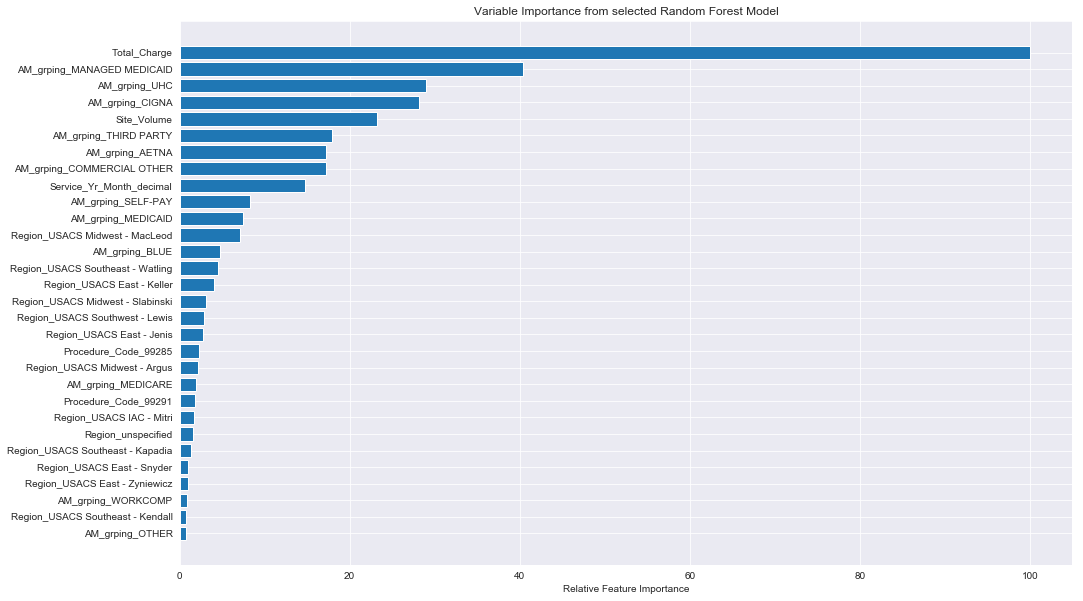

In [232]:
# Make importances relative to max importance.
feature_importance = rfr_key.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(16,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, rfr_key_cols[sorted_idx])
plt.xlabel('Relative Feature Importance')
plt.title('Variable Importance from selected Random Forest Model')
plt.show()

In [234]:
#All columns
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

df_results_grid_key_lr, df_results_key_lr, lr_key, lr_key_cols = results_grid(X_train_key_cols, X_test_key_cols, 'Total_Payment_20170131',False, False, colList, scaleColList,LinearRegression())
df_results_grid_key_lr

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,7.433178e+02,2.318840e+01,1.601820e+02,1.369936e+02,0.215496,-3.244437e+09,-3.244437e+09,3.244437e+09,2.368313e+07,2.282547e+10,-4.149349e+10,4.798237e+10
1,5,4.136260e+03,1.294878e+02,8.747772e+02,7.452894e+02,0.211490,-1.459997e+10,-1.459997e+10,1.459997e+10,1.958966e+07,4.665882e+10,-7.685131e+10,1.060512e+11
2,10,8.541943e+03,2.881082e+02,1.661816e+03,1.373708e+03,0.194548,-3.082215e+10,-3.082215e+10,3.082215e+10,2.243719e+07,6.798945e+10,-1.024372e+11,1.640815e+11
3,50,4.209761e+04,1.690465e+03,8.236492e+03,6.546028e+03,0.195652,-1.443774e+11,-1.443774e+11,1.443775e+11,2.205573e+07,1.419377e+11,-1.338204e+11,4.225753e+11
4,100,8.428614e+04,3.113918e+03,1.662584e+04,1.351193e+04,0.197255,-2.465772e+11,-2.465772e+11,2.465772e+11,1.824886e+07,2.055586e+11,-1.563177e+11,6.494721e+11
5,500,4.223687e+05,1.567827e+04,8.321031e+04,6.753203e+04,0.197009,-1.370775e+12,-1.370775e+12,1.370775e+12,2.029814e+07,4.322074e+11,5.236482e+11,2.217901e+12
6,1000,8.458454e+05,3.153053e+04,1.666224e+05,1.350919e+05,0.196989,-2.595550e+12,-2.595550e+12,2.595550e+12,1.921321e+07,6.087278e+11,1.402443e+12,3.788656e+12
7,5000,4.227250e+06,1.575474e+05,8.326084e+05,6.750610e+05,0.196962,-1.334924e+13,-1.334924e+13,1.334924e+13,1.977486e+07,1.357695e+12,1.068815e+13,1.601032e+13
8,10000,8.458008e+06,3.153667e+05,1.668342e+06,1.352976e+06,0.197250,-2.692720e+13,-2.692720e+13,2.692721e+13,1.990221e+07,1.933852e+12,2.313686e+13,3.071756e+13
9,25000,2.114852e+07,7.886504e+05,4.169509e+06,3.380859e+06,0.197154,-6.782495e+13,-6.782495e+13,6.782496e+13,2.006146e+07,2.837770e+12,6.226293e+13,7.338699e+13


In [237]:
#All columns
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

df_results_grid_key_ridge, df_results_key_ridge, ridge_key, ridge_key_cols = results_grid(X_train_key_cols, X_test_key_cols, 'Total_Payment_20170131',False, False, colList, scaleColList,Ridge())
df_results_grid_key_ridge

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.197606e+02,1.565400e+01,1.520588e+02,1.364048e+02,0.185492,1.646034e+02,1.489494e+02,7.496971e+01,0.549612,1.223651e+02,-1.648660e+02,3.148054e+02
1,5,4.200019e+03,1.610326e+02,7.899374e+02,6.289048e+02,0.188079,8.158211e+02,6.547885e+02,2.109715e+02,0.335459,1.909313e+02,-1.632539e+02,5.851969e+02
2,10,8.160015e+03,3.433765e+02,1.658882e+03,1.315505e+03,0.203294,1.573837e+03,1.230460e+03,3.798679e+02,0.288762,3.070189e+02,-2.218892e+02,9.816250e+02
3,50,4.259281e+04,1.625879e+03,8.174073e+03,6.548194e+03,0.191912,8.146310e+03,6.520431e+03,7.298361e+02,0.111456,5.624601e+02,-3.725857e+02,1.832258e+03
4,100,8.437968e+04,3.055883e+03,1.672496e+04,1.366908e+04,0.198211,1.634832e+04,1.329243e+04,1.219740e+03,0.089234,9.839382e+02,-7.087786e+02,3.148259e+03
5,500,4.225552e+05,1.593837e+04,8.355650e+04,6.761813e+04,0.197741,8.079577e+04,6.485739e+04,3.060618e+03,0.045263,2.278762e+03,-1.405755e+03,7.526991e+03
6,1000,8.461931e+05,3.165806e+04,1.672657e+05,1.356076e+05,0.197668,1.625922e+05,1.309341e+05,5.149494e+03,0.037973,3.165704e+03,-1.055285e+03,1.135427e+04
7,5000,4.224090e+06,1.572154e+05,8.326806e+05,6.754653e+05,0.197127,8.114634e+05,6.542480e+05,2.134997e+04,0.031608,9.476689e+03,2.775655e+03,3.992428e+04
8,10000,8.452735e+06,3.134104e+05,1.670186e+06,1.356776e+06,0.197591,1.624187e+06,1.310776e+06,4.599991e+04,0.033904,1.516269e+04,1.628103e+04,7.571878e+04
9,25000,2.113268e+07,7.892060e+05,4.170911e+06,3.381705e+06,0.197368,4.060018e+06,3.270812e+06,1.108936e+05,0.032792,2.388633e+04,6.407643e+04,1.577108e+05


In [238]:
#All columns
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

df_results_grid_key_mlp, df_results_key_mlp, mlp_key, mlp_key_cols = results_grid(X_train_key_cols, X_test_key_cols, 'Total_Payment_20170131',False, False, colList, scaleColList,MLPRegressor(hidden_layer_sizes=(5)))
df_results_grid_key_mlp


C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.713726e+02,2.522420e+01,1.267660e+02,1.015418e+02,0.145479,1.464006e+02,1.211764e+02,4.847722e+01,0.477411,8.264747e+01,-1.135118e+02,2.104663e+02
1,5,4.213665e+03,1.674932e+02,8.453362e+02,6.778430e+02,0.200618,8.197753e+02,6.522821e+02,1.604483e+02,0.236704,2.058867e+02,-2.430896e+02,5.639862e+02
2,10,8.362625e+03,3.378967e+02,1.657934e+03,1.320037e+03,0.198255,1.590446e+03,1.252549e+03,2.745695e+02,0.208001,2.944093e+02,-3.024727e+02,8.516117e+02
3,50,4.234982e+04,1.562695e+03,8.300892e+03,6.738197e+03,0.196008,8.068000e+03,6.505305e+03,6.560329e+02,0.097360,6.472459e+02,-6.125690e+02,1.924635e+03
4,100,8.422973e+04,3.079854e+03,1.616948e+04,1.308962e+04,0.191969,1.593810e+04,1.285824e+04,9.250362e+02,0.070669,7.691336e+02,-5.824656e+02,2.432538e+03
5,500,4.236715e+05,1.594850e+04,8.363748e+04,6.768899e+04,0.197411,8.109304e+04,6.514454e+04,3.109342e+03,0.045936,2.100222e+03,-1.007093e+03,7.225778e+03
6,1000,8.448825e+05,3.097435e+04,1.663470e+05,1.353727e+05,0.196888,1.614553e+05,1.304809e+05,5.158166e+03,0.038103,3.585763e+03,-1.869930e+03,1.218626e+04
7,5000,4.226188e+06,1.577397e+05,8.355168e+05,6.777770e+05,0.197700,8.111122e+05,6.533725e+05,2.440452e+04,0.036007,9.497209e+03,5.789990e+03,4.301905e+04
8,10000,8.461267e+06,3.153611e+05,1.671096e+06,1.355735e+06,0.197500,1.620376e+06,1.305015e+06,5.072081e+04,0.037412,1.335990e+04,2.453541e+04,7.690622e+04
9,25000,2.115337e+07,7.855588e+05,4.170554e+06,3.384995e+06,0.197158,4.044576e+06,3.259017e+06,1.259779e+05,0.037217,1.954890e+04,8.766204e+04,1.642937e+05


In [242]:
#All columns
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

df_results_grid_key_mlp, df_results_key_mlp, mlp_key, mlp_key_cols = results_grid(X_train_key_cols, X_test_key_cols, 'Total_Payment_20170131',False, False, colList, scaleColList,MLPRegressor(hidden_layer_sizes=(10)))
df_results_grid_key_mlp

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.736173e+02,4.341900e+01,1.537733e+02,1.103543e+02,0.176019,1.547782e+02,1.113592e+02,4.548642e+01,0.412185,9.589575e+01,-1.424692e+02,2.334421e+02
1,5,4.223481e+03,1.546394e+02,8.036282e+02,6.489888e+02,0.190276,8.286888e+02,6.740494e+02,1.815126e+02,0.279685,1.860023e+02,-1.830518e+02,5.460771e+02
2,10,8.413234e+03,3.283829e+02,1.637351e+03,1.308968e+03,0.194616,1.613344e+03,1.284961e+03,2.943310e+02,0.224857,2.615449e+02,-2.182970e+02,8.069589e+02
3,50,4.213735e+04,1.545201e+03,8.457304e+03,6.912103e+03,0.200708,8.168899e+03,6.623698e+03,6.991927e+02,0.101155,5.479766e+02,-3.748414e+02,1.773227e+03
4,100,8.408631e+04,3.166982e+03,1.666286e+04,1.349588e+04,0.198164,1.623257e+04,1.306559e+04,1.121543e+03,0.083103,8.975647e+02,-6.376834e+02,2.880770e+03
5,500,4.246474e+05,1.612104e+04,8.376675e+04,6.764571e+04,0.197262,8.183166e+04,6.571062e+04,2.636485e+03,0.038975,2.181721e+03,-1.639688e+03,6.912658e+03
6,1000,8.455092e+05,3.154562e+04,1.669143e+05,1.353687e+05,0.197413,1.633509e+05,1.318052e+05,4.303451e+03,0.031791,2.683885e+03,-9.569639e+02,9.563867e+03
7,5000,4.227924e+06,1.570967e+05,8.341316e+05,6.770349e+05,0.197291,8.152104e+05,6.581137e+05,1.919191e+04,0.028347,8.704085e+03,2.131906e+03,3.625192e+04
8,10000,8.455286e+06,3.125961e+05,1.668620e+06,1.356023e+06,0.197346,1.628366e+06,1.315770e+06,4.025392e+04,0.029685,1.303314e+04,1.470896e+04,6.579887e+04
9,25000,2.116340e+07,7.897516e+05,4.175692e+06,3.385941e+06,0.197307,4.075688e+06,3.285936e+06,1.000049e+05,0.029535,1.906604e+04,6.263545e+04,1.373743e+05


In [243]:
#All columns
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

df_results_grid_key_bag, df_results_key_bag, bag_key, bag_key_cols = results_grid(X_train_key_cols, X_test_key_cols, 'Total_Payment_20170131',False, False, colList, scaleColList,BaggingRegressor())
df_results_grid_key_bag

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.756721e+02,3.987300e+01,1.695325e+02,1.296595e+02,0.193603,1.646599e+02,1.247869e+02,56.225283,0.433638,1.047433e+02,-149.071572,261.522138
1,5,4.262382e+03,1.769259e+02,8.720705e+02,6.951446e+02,0.204597,8.204513e+02,6.435254e+02,203.344590,0.292521,1.993845e+02,-187.448989,594.138169
2,10,8.417557e+03,3.123126e+02,1.682548e+03,1.370235e+03,0.199886,1.711197e+03,1.398885e+03,306.506745,0.223689,3.437305e+02,-367.205018,980.218507
3,50,4.155468e+04,1.543326e+03,8.345532e+03,6.802206e+03,0.200833,8.292503e+03,6.749177e+03,757.375955,0.111343,6.785676e+02,-572.616447,2087.368358
4,100,8.462261e+04,3.112886e+03,1.654322e+04,1.343034e+04,0.195494,1.660195e+04,1.348907e+04,1180.288992,0.087882,8.448961e+02,-475.707360,2836.285345
5,500,4.223345e+05,1.555985e+04,8.335066e+04,6.779081e+04,0.197357,8.350889e+04,6.794904e+04,2297.638741,0.033893,1.697955e+03,-1030.353384,5625.630866
6,1000,8.475153e+05,3.128234e+04,1.684252e+05,1.371428e+05,0.198728,1.691043e+05,1.378220e+05,3526.925311,0.025717,2.851410e+03,-2061.837493,9115.688114
7,5000,4.228150e+06,1.570405e+05,8.343003e+05,6.772598e+05,0.197320,8.368109e+05,6.797704e+05,8011.659790,0.011830,5.716897e+03,-3193.457492,19216.777072
8,10000,8.462682e+06,3.157004e+05,1.671541e+06,1.355840e+06,0.197519,1.676721e+06,1.361020e+06,10861.054617,0.008011,8.919757e+03,-6621.669760,28343.778994
9,25000,2.113131e+07,7.860817e+05,4.166477e+06,3.380396e+06,0.197171,4.179120e+06,3.393038e+06,20368.017958,0.006025,1.393988e+04,-6954.142245,47690.178161


In [120]:
lasso_coeffs = pd.DataFrame(list(zip(lso.coef_, X.columns)))
lasso_coeffs.columns = ['coeff','col']
lasso_coeffs.sort_values('coeff',ascending=False)
lasso_coeffs.to_csv('lasso.csv')

In [129]:
rfr_coeffs = pd.DataFrame(list(zip(rfr.feature_importances_, X.columns)))
rfr_coeffs.columns = ['feature_importance','col']
rfr_coeffs.sort_values('feature_importance',ascending=False)
rfr_coeffs.to_csv('rfr.csv')

In [274]:
#GSR
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

n_list =  [1,5,10,50,100,500,1000,5000,10000,25000,50000,100000,300000,500000,752139]

df_results_grid_key_bag_02, df_results_key_bag_02, bag_key_02 = results_grid(X_train_key_cols_0228, X_test_key_cols_0228, 'Total_Payment_20170228',True, False, colList, scaleColList, BaggingRegressor(),n_list)
df_results_grid_key_bag_02

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.327919e+02,3.465500e+01,1.592197e+02,1.245647e+02,0.191188,1.565767e+02,1.219217e+02,5.610586e+01,0.450415,1.121075e+02,-1.636249e+02,2.758366e+02
1,5,4.209741e+03,1.732535e+02,8.068005e+02,6.335470e+02,0.191651,8.922940e+02,7.190405e+02,2.177365e+02,0.343678,2.197220e+02,-2.129187e+02,6.483917e+02
2,10,8.361399e+03,3.284152e+02,1.654391e+03,1.325976e+03,0.197861,1.812282e+03,1.483867e+03,3.337267e+02,0.251684,3.046111e+02,-2.633111e+02,9.307644e+02
3,50,4.266255e+04,1.736197e+03,8.403018e+03,6.666821e+03,0.196965,9.127945e+03,7.391748e+03,9.270701e+02,0.139057,6.721784e+02,-3.903997e+02,2.244540e+03
4,100,8.456155e+04,3.257586e+03,1.654323e+04,1.328565e+04,0.195635,1.814526e+04,1.488767e+04,1.675003e+03,0.126076,1.094327e+03,-4.698775e+02,3.819884e+03
5,500,4.283697e+05,1.752790e+04,8.441728e+04,6.688938e+04,0.197066,9.162481e+04,7.409691e+04,7.207527e+03,0.107753,3.208077e+03,9.196968e+02,1.349536e+04
6,1000,8.568507e+05,3.452338e+04,1.667546e+05,1.322312e+05,0.194613,1.822677e+05,1.477443e+05,1.551315e+04,0.117318,3.678910e+03,8.302491e+03,2.272382e+04
7,5000,4.277069e+06,1.726072e+05,8.393416e+05,6.667344e+05,0.196242,9.109433e+05,7.383361e+05,7.160169e+04,0.107392,9.021432e+03,5.391968e+04,8.928369e+04
8,10000,8.541928e+06,3.432893e+05,1.678359e+06,1.335069e+06,0.196485,1.821369e+06,1.478079e+06,1.430099e+05,0.107118,1.178187e+04,1.199175e+05,1.661024e+05
9,25000,2.137173e+07,8.596744e+05,4.203385e+06,3.343710e+06,0.196680,4.557470e+06,3.697796e+06,3.540854e+05,0.105896,1.705492e+04,3.206578e+05,3.875130e+05


In [279]:
#Bagger
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']
n_list =  [1,5,10,50,100,500,1000,5000,10000,25000,50000,100000,300000,500000,752139]

df_results_grid_key_bag_02, df_results_key_bag_02, bag_key_02, bag_key_cols_02 = results_grid(X_train_key_cols_0228, X_test_key_cols_0228, 'Total_Payment_20170228',False, False, colList, scaleColList, BaggingRegressor(),n_list)
df_results_grid_key_bag_02

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,7.860988e+02,2.342050e+01,1.390793e+02,1.156588e+02,0.176923,1.380116e+02,1.145911e+02,55.191948,0.477196,1.109596e+02,-162.288959,272.672855
1,5,4.382523e+03,1.744249e+02,8.473396e+02,6.729147e+02,0.193345,8.781450e+02,7.037201e+02,219.426108,0.326083,2.483516e+02,-267.342940,706.195156
2,10,8.715379e+03,3.587221e+02,1.703856e+03,1.345134e+03,0.195500,1.681676e+03,1.322954e+03,302.084502,0.224576,3.070381e+02,-299.710207,903.879212
3,50,4.250634e+04,1.760896e+03,8.266667e+03,6.505772e+03,0.194481,8.187058e+03,6.426162e+03,759.106354,0.116682,6.379788e+02,-491.332070,2009.544779
4,100,8.458580e+04,3.289110e+03,1.674898e+04,1.345987e+04,0.198012,1.656972e+04,1.328061e+04,1226.396396,0.091115,8.652022e+02,-469.399873,2922.192664
5,500,4.276033e+05,1.712669e+04,8.364878e+04,6.652210e+04,0.195622,8.326208e+04,6.613540e+04,2395.746676,0.036014,1.798403e+03,-1129.123054,5920.616406
6,1000,8.544310e+05,3.410542e+04,1.683415e+05,1.342361e+05,0.197022,1.673500e+05,1.332446e+05,3201.869256,0.023853,2.420874e+03,-1543.044310,7946.782823
7,5000,4.275664e+06,1.733232e+05,8.433142e+05,6.699911e+05,0.197236,8.384300e+05,6.651068e+05,10365.302747,0.015471,7.218991e+03,-3783.920031,24514.525525
8,10000,8.546583e+06,3.439020e+05,1.678056e+06,1.334154e+06,0.196342,1.671880e+06,1.327978e+06,12240.984132,0.009175,9.822421e+03,-7010.961932,31492.930196
9,25000,2.137299e+07,8.615645e+05,4.198837e+06,3.337273e+06,0.196455,4.180356e+06,3.318791e+06,22958.400253,0.006879,1.655107e+04,-9481.690762,55398.491269


In [285]:
#GSR
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

n_list =  [1,5,10,50,100,500,1000,5000,10000,25000,50000,100000,300000,500000,768055]

df_results_grid_key_bag_02, df_results_key_bag_02, bag_key_02 = results_grid(X_train_key_cols_0331, X_test_key_cols_0331, 'Total_Payment_20170331',True, False, colList, scaleColList, BaggingRegressor(),n_list)
df_results_grid_key_bag_02

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.044390e+02,2.653350e+01,1.531541e+02,1.266206e+02,0.190386,1.710086e+02,1.444751e+02,5.342104e+01,0.421898,9.128616e+01,-1.254998e+02,2.323419e+02
1,5,4.174762e+03,2.021790e+02,8.332522e+02,6.310732e+02,0.199593,8.462740e+02,6.440950e+02,2.046748e+02,0.324328,2.168842e+02,-2.204182e+02,6.297677e+02
2,10,8.856591e+03,4.122193e+02,1.596489e+03,1.184270e+03,0.180260,1.712586e+03,1.300367e+03,2.658659e+02,0.224498,2.392038e+02,-2.029737e+02,7.347054e+02
3,50,4.279240e+04,1.861771e+03,8.224903e+03,6.363132e+03,0.192205,8.919470e+03,7.057699e+03,8.848287e+02,0.139056,6.164583e+02,-3.234296e+02,2.093087e+03
4,100,8.465048e+04,3.718805e+03,1.657741e+04,1.285861e+04,0.195834,1.790918e+04,1.419038e+04,1.588895e+03,0.123567,1.047748e+03,-4.646910e+02,3.642482e+03
5,500,4.291586e+05,1.914359e+04,8.320933e+04,6.406573e+04,0.193889,9.044517e+04,7.130157e+04,7.242094e+03,0.113042,2.884224e+03,1.589015e+03,1.289517e+04
6,1000,8.572399e+05,3.798881e+04,1.665104e+05,1.285216e+05,0.194240,1.800572e+05,1.420684e+05,1.354678e+04,0.105405,3.584681e+03,6.520808e+03,2.057276e+04
7,5000,4.281832e+06,1.873981e+05,8.287499e+05,6.413518e+05,0.193550,9.008758e+05,7.134777e+05,7.212583e+04,0.112459,9.947431e+03,5.262886e+04,9.162279e+04
8,10000,8.576594e+06,3.768876e+05,1.659629e+06,1.282742e+06,0.193507,1.802017e+06,1.425130e+06,1.423881e+05,0.111003,1.225001e+04,1.183780e+05,1.663981e+05
9,25000,2.141408e+07,9.412910e+05,4.149244e+06,3.207953e+06,0.193762,4.505306e+06,3.564015e+06,3.560619e+05,0.110994,1.958711e+04,3.176712e+05,3.944527e+05


In [286]:
#Bagger
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']
n_list =  [1,5,10,50,100,500,1000,5000,10000,25000,50000,100000,300000,500000,768055]

df_results_grid_key_bag_02, df_results_key_bag_02, bag_key_02, bag_key_cols_02 = results_grid(X_train_key_cols_0331, X_test_key_cols_0331, 'Total_Payment_20170331',False, False, colList, scaleColList, BaggingRegressor(),n_list)
df_results_grid_key_bag_02

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.193790e+02,3.657100e+01,1.479401e+02,1.113691e+02,0.180551,1.500178e+02,1.134468e+02,38.406637,0.344859,9.016868e+01,-138.323967,215.137240
1,5,4.163145e+03,1.972869e+02,8.435848e+02,6.462979e+02,0.202632,8.305590e+02,6.332721e+02,203.946789,0.315562,2.008410e+02,-189.701662,597.595239
2,10,8.156655e+03,3.304974e+02,1.547983e+03,1.217486e+03,0.189782,1.597347e+03,1.266849e+03,296.150197,0.243247,2.626135e+02,-218.572245,810.872639
3,50,4.356152e+04,1.898047e+03,8.265979e+03,6.367932e+03,0.189754,8.242070e+03,6.344023e+03,777.569276,0.122107,6.892836e+02,-573.426667,2128.565218
4,100,8.585549e+04,3.664246e+03,1.675952e+04,1.309528e+04,0.195206,1.662547e+04,1.296123e+04,1144.726571,0.087415,9.028642e+02,-624.887336,2914.340477
5,500,4.272872e+05,1.883365e+04,8.368956e+04,6.485591e+04,0.195863,8.317160e+04,6.433796e+04,2443.930671,0.037682,1.683354e+03,-855.442304,5743.303645
6,1000,8.596328e+05,3.783992e+04,1.662781e+05,1.284382e+05,0.193429,1.663979e+05,1.285580e+05,3159.939153,0.024603,2.209186e+03,-1170.065854,7489.944160
7,5000,4.280217e+06,1.892535e+05,8.297850e+05,6.405315e+05,0.193865,8.267204e+05,6.374668e+05,8438.878830,0.013175,6.513339e+03,-4327.265002,21205.022662
8,10000,8.565377e+06,3.758632e+05,1.657650e+06,1.281786e+06,0.193529,1.651315e+06,1.275451e+06,11359.579720,0.008862,8.560140e+03,-5418.295126,28137.454566
9,25000,2.141617e+07,9.441142e+05,4.151857e+06,3.207742e+06,0.193866,4.138136e+06,3.194022e+06,19894.295118,0.006202,1.503630e+04,-9576.856641,49365.446876


In [287]:
#GSR
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']

n_list =  [1,5,10,50,100,500,1000,5000,10000,25000,50000,100000,300000,500000,745710]

df_results_grid_key_bag_02, df_results_key_bag_02, bag_key_02 = results_grid(X_train_key_cols_0430, X_test_key_cols_0430, 'Total_Payment_20170430',True, False, colList, scaleColList, BaggingRegressor(),n_list)
df_results_grid_key_bag_02

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,8.638927e+02,2.879660e+01,1.697204e+02,1.409238e+02,0.196460,1.753735e+02,1.465769e+02,6.043638e+01,0.428859,1.188736e+02,-1.725559e+02,2.934287e+02
1,5,4.395999e+03,1.736691e+02,8.768657e+02,7.031966e+02,0.199469,9.113477e+02,7.376786e+02,1.788617e+02,0.254355,1.639308e+02,-1.424426e+02,5.001660e+02
2,10,8.734618e+03,2.891218e+02,1.594830e+03,1.305708e+03,0.182587,1.756989e+03,1.467867e+03,3.215845e+02,0.246291,2.717208e+02,-2.109882e+02,8.541572e+02
3,50,4.258501e+04,1.555157e+03,8.164256e+03,6.609098e+03,0.191717,8.747133e+03,7.191976e+03,9.005105e+02,0.136253,5.984523e+02,-2.724560e+02,2.073477e+03
4,100,8.530890e+04,3.342722e+03,1.647144e+04,1.312872e+04,0.193080,1.773155e+04,1.438883e+04,1.496267e+03,0.113969,9.415204e+02,-3.491127e+02,3.341647e+03
5,500,4.257569e+05,1.705186e+04,8.168189e+04,6.463003e+04,0.191851,8.704067e+04,6.998881e+04,5.358778e+03,0.082915,2.429768e+03,5.964319e+02,1.012112e+04
6,1000,8.564496e+05,3.453544e+04,1.642818e+05,1.297464e+05,0.191817,1.761101e+05,1.415747e+05,1.182830e+04,0.091165,4.216855e+03,3.563267e+03,2.009334e+04
7,5000,4.284455e+06,1.680175e+05,8.238007e+05,6.557832e+05,0.192277,8.827869e+05,7.147694e+05,5.898616e+04,0.089948,8.762625e+03,4.181141e+04,7.616090e+04
8,10000,8.559659e+06,3.386341e+05,1.643623e+06,1.304989e+06,0.192020,1.757543e+06,1.418909e+06,1.139203e+05,0.087296,1.178761e+04,9.081662e+04,1.370241e+05
9,25000,2.140127e+07,8.426789e+05,4.107009e+06,3.264330e+06,0.191905,4.398880e+06,3.556201e+06,2.918709e+05,0.089412,2.284891e+04,2.470871e+05,3.366548e+05


In [288]:
#Bagger
scaleColList = ['Service_Yr_Month_decimal','Total_Charge','Site_Volume']
colList = ['Total_Charge','Service_Yr_Month_decimal','AM_grping','Region','Site_Volume','Procedure_Code']
n_list =  [1,5,10,50,100,500,1000,5000,10000,25000,50000,100000,300000,500000,745710]

df_results_grid_key_bag_02, df_results_key_bag_02, bag_key_02, bag_key_cols_02 = results_grid(X_train_key_cols_0430, X_test_key_cols_0430, 'Total_Payment_20170430',False, False, colList, scaleColList, BaggingRegressor(),n_list)
df_results_grid_key_bag_02

C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lkonig\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,n,charge,actual_asof,actual,actual_post_asof,ratio,pred,pred_post_asof,diff,pct,stdev,ci_1,ci_2
0,1,7.725985e+02,3.707280e+01,1.559267e+02,1.188539e+02,0.201821,1.621591e+02,1.250863e+02,6.829521e+01,0.574615,1.436259e+02,-2.132116e+02,3.498020e+02
1,5,4.213641e+03,2.170763e+02,8.377103e+02,6.206340e+02,0.198809,8.306046e+02,6.135283e+02,1.943558e+02,0.313157,2.377897e+02,-2.717120e+02,6.604235e+02
2,10,8.693598e+03,2.919236e+02,1.604577e+03,1.312653e+03,0.184570,1.654923e+03,1.362999e+03,2.835243e+02,0.215993,2.644354e+02,-2.347690e+02,8.018176e+02
3,50,4.334571e+04,1.816585e+03,8.454565e+03,6.637980e+03,0.195050,8.504858e+03,6.688273e+03,7.466019e+02,0.112474,6.309719e+02,-4.901031e+02,1.983307e+03
4,100,8.594562e+04,3.245450e+03,1.634212e+04,1.309667e+04,0.190145,1.670903e+04,1.346358e+04,1.124055e+03,0.085828,8.652557e+02,-5.718464e+02,2.819956e+03
5,500,4.271212e+05,1.702873e+04,8.148472e+04,6.445599e+04,0.190777,8.295608e+04,6.592735e+04,3.296025e+03,0.051136,2.276733e+03,-1.166373e+03,7.758423e+03
6,1000,8.574854e+05,3.363524e+04,1.650313e+05,1.313960e+05,0.192460,1.677818e+05,1.341466e+05,4.168632e+03,0.031726,3.376759e+03,-2.449815e+03,1.078708e+04
7,5000,4.282269e+06,1.694262e+05,8.215080e+05,6.520818e+05,0.191839,8.331239e+05,6.636977e+05,1.278210e+04,0.019602,7.654504e+03,-2.220730e+03,2.778492e+04
8,10000,8.569940e+06,3.388504e+05,1.642095e+06,1.303244e+06,0.191611,1.665119e+06,1.326269e+06,2.326746e+04,0.017853,1.299939e+04,-2.211338e+03,4.874626e+04
9,25000,2.140667e+07,8.443463e+05,4.104278e+06,3.259932e+06,0.191729,4.164786e+06,3.320440e+06,6.050784e+04,0.018561,2.127579e+04,1.880729e+04,1.022084e+05


In [6]:
#charges by service date
sql = """

select 
    Service_Date
    ,SUM(Total_Charge ) Total_Charge
    ,count(*) Total_Count
from 
    AM_tbl_Claims_Trans_GROUPED
where
    Service_Date < '2018-06-01'
group by
    Service_Date
order by
    Service_Date
"""

df_service_date_metrics = pd.io.sql.read_sql(sql, conn)
df_service_date_metrics.head()

,Service_Date,Total_Charge,Total_Count
0,2014-01-01,4.117018e+06,9850
1,2014-01-02,3.948036e+06,9356
2,2014-01-03,3.870720e+06,9207
3,2014-01-04,4.023027e+06,9611
4,2014-01-05,3.842606e+06,9215
